# Indeed Text Mining Analysis

In this notebook we're analyzing the data pulled from Indeed and check the data, how the company is viewed, how to employees feel, what are the most talked about pros and cons of working here

In [1]:
# Data handling
import numpy as np
import pandas as pd
import string
import re
from datetime import datetime
import dateutil.parser
# Data visualization
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from pandas.plotting import table
# Preprocessing and Modelling
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import matplotlib.cm as cm
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Configuration warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the dataset
df = pd.read_excel(r"C:\Users\guena\Mcdonald's Reviews.xlsx")

#Renaming the First Column as ID
df.rename(columns={'Unnamed: 0':'ID'}, inplace=True)

#Check rows
df.head(5)

,ID,review title,review,pros,cons,date,job,location,rating
0,0,Customers are disgustingly rude,I’ve been working at McDonald’s for a year and...,"Free meals, benefits, pay, flexibility","Long hours, exhausting, horrible treatment fro...","May 14, 2021",McDonalds Crew Member,Telford,3.0
1,1,"Productive, good to learn new skills and devel...",Working here helped me gain confidence when ta...,NaN,NaN,"February 19, 2020",McDonalds Crew Member,Dorchester,4.0
2,2,Workplace,Workplace is high pressure and high demand. Ma...,NaN,NaN,"February 19, 2020",Crew Trainer,"Hazel Grove, Greater Manchester",1.0
3,3,McDonald's merthyr,Enjoy working at Mcdonald for the sort period ...,NaN,NaN,"February 19, 2020",Crew Member,Merthyr Tydfil,4.0
4,4,Good first time job,A very fast paced place to work. You are able ...,NaN,NaN,"February 18, 2020",Crew Member,Crawley,5.0


In [3]:
#Check Columns Names
print(list(df.columns.values))

['ID', 'review title', 'review', 'pros', 'cons', 'date', 'job', 'location', 'rating']


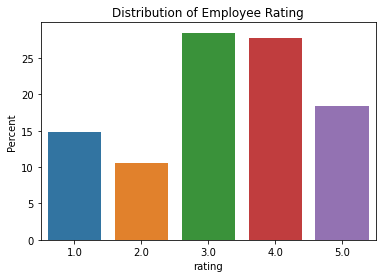

In [4]:
#Plot the % rating in the data set
ax = sns.barplot(data=df, x='rating', y='rating', estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")
plt.title('Distribution of Employee Rating')
plt.show()

In [5]:
#Summary statistics for all columns
summary=df.describe(include='all')
summary=summary.transpose()
summary.head(len(summary))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,4053.0,NaN,NaN,NaN,2026.0,1170.144649,0.0,1013.0,2026.0,3039.0,4052.0
review title,4052,2706,Customers are disgustingly rude,193,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review,4053,3718,I’ve been working at McDonald’s for a year and...,193,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pros,1749,896,"Free meals, benefits, pay, flexibility",193,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cons,1748,1188,"Long hours, exhausting, horrible treatment fro...",193,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,4053,735,"May 14, 2021",195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job,4046,567,Crew Member,1260,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,4053,1517,Telford,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,4053.0,NaN,NaN,NaN,3.244017,1.284318,1.0,2.0,3.0,4.0,5.0


### Data Cleaning

In this Segment we're cleaning the data becasue there's multiple stuff that can bee tweaked to get beter results:

1. We have some jobs that might be empty
2. We  may have jobs that mean the same thing but written in different ways(upper/lower case, location, typos etc)
3. The date is not ideal since we're in Europe and a key concern about data is visualization is being east to read
4. To make text mining we want text to be as homogeneous as possible

In [6]:
#Missing Values
print(df.isnull().count())

#Filling Missing Values with the mode
df['job'].fillna(df['job'].mode(), inplace=True)

ID              4053
review title    4053
review          4053
pros            4053
cons            4053
date            4053
job             4053
location        4053
rating          4053
dtype: int64


In [7]:
#Order the Jobs descriptions to check if we have jobs saying the same thing
df.groupby(by ="job")["review"].count().sort_values(ascending = False)

job
Crew Member                         1260
McDonalds Crew Member                407
Crew Member - Part Time              244
Crew Trainer                         205
Shift Manager                        164
                                    ... 
Customer assistant                     1
Customer Services Team Leader          1
Customer Services Advisor              1
Customer Service and Hospitality       1
work at till                           1
Name: review, Length: 567, dtype: int64

In [8]:
# Cleaning the Crew Member Job Title
df['job'] = df['job'].replace(["Crew member","PART TIME CREW MEMBER","McDonalds Crew Member","Crew Member - Part Time","Crew Member - Full Time","Crew member McDonalds",
                               "McDonald's Crew Member","Part time Crew member","Part-Time Crew Member","CREW MEMBER/TRAINER","Crew member (Part time)","CREW MEMBER","crew member",
                               "Crew Member/Crew Trainer","Kitchen Crew Member","Crew Member/customer experience leader","Crew Member - Night Shift","Fast-Food Crew Member",
                               "CREW MEMBER AT MCDONALDS","Cashier/Crew Member","Crew member to shift manager","Training new crew member/ staff","Early Crew Member","Crew Member/Customer Service Assist",
                               "crew member & maintenance","Lord St - Crew Member","Crew Member (Full-Time)","Crew Member/Crewe Trainer","Crew Member - Dates of Employment","Crew Member\Customer Care","Crew Member (temporary)",
                               "Full Time Crew Member","Crew Member / Customer care lead","Stranmore - Crew Member","CREW MEMBER / MCDOANLD'S","Crew Member/Area Leader","Crew Member / Trainee Manager","Crew Member - McDonalds",
                               "Crew Member • Spalding, Lincolnshire","Crew Member/Staff Trainer","Crew Member and Customer service","Customer Care Assistant/Crew Member","Crew Member and lobby staff","Bedford. - Crew member",
                               "Crew Member and maintenance man","General crew member","Crew member and manager ","Shift Manager, Crew Trainer, Crew Member","Basildon- Crew Member","Temporary Crew Member","Crew Member cel","Workington- crew member",
                               "Crew Member in the Street","Crew Member - Manager","Being crew member","Crew Member/Customer Care","Crew member McDonalds-full time","Crew Member/customer service","Crew Member member","Crew Member/Delivery Manager",
                               "Crew Member Merry Hill (Temporary)","CREW MEMBER - CREW TRAINER - KITCHEN MANAGER","Crew member nights","Crew Trainer and Crew Member","Crew Member part time","customer service crew member","MacDonald's Crew Member",
                               "FAST FOOD CREW MEMBER","Mc Donalds Crew Member","Full time - Crew Member Apprentice","McDonald’s nightshift crew member","fulltime overnight crew member","Crew Member - Full Time overnights","Crew Member - Summer",
                               "McDonalds Crew Member (Sutton in Ashfield)","Crew Member & Crew Trainer","Crew Member -","McDonald’s Crew Member","Crew Member trained","Mcdonald's / Crew Member","Overnight Crew Member","Chirk Retail Park - Crew Member",
                               "Part Time Crew Member McDonald’s","McDonalds Crew Member/trainer","McDonalds Crew Member’s ","My tasks in my role as crew member","Area Manager/Crew Member","Senior Crew Member","Crew Member trainee","Part Time- McDonald's Crew Member",
                               "crew member Westwood cross","Quick service restaurant crew member","Crew Member, being able","Server/Crew Member","Crew Member, Caerphilly","Star Qualified Crew Member","Crew Member, Cowdray Avenue","Team crew member","Crew Member, Markham Moor",
                               "Trainee crew member","Crew Member, McArthur Glen Food Court","United Kingdom - Crew Member","Crew member/ crew trainer","(Crew Member) Manchester Eccles West One","Crew Member/ Kitchen","crew memeber","CREW","Service Crew","Crewman","McDonalds Crew",
                               "McDonald's Crew","crew worker","Crewmember","Crew Leader","kitchen crew","Crew Person","Crew traineer","Night Crew/Delivery manager","Crew, night man","McDonalds Crew Mcdonalds","Connswater- Crewmember","Night crew","Crew assistant","Crew Cabin",
                               "Kitchen Crew, Delivery Crew, Maintenance Crew","Leeds - Crew","Whirlies - Crew","Crew Memebr","Maintenance Crew","crey member","Ctew member"],'Crew Member')
#CLeaning Crew trainer Title
df['job'] = df['job'].replace(["Part-time Crew Trainer","Crew Trainer - Full Time","Crew Trainer McDonalds","McDonalds Crew Trainer",
                               "CREW MEMBER/TRAINER","Crew Trainer/Trainee Manager","Crew Member/Crew Trainer","Part-Time Crew Trainer",
                               "Crew Member & Crew Trainer","Crew Trainer ","Crew trainer - part time","Crew trainer / training manger",
                               "Crew Trainer and Crew Member","Crew Trainer I","Manager/Crew Trainer","Crew Trainer in July 2019",
                               "Crew Trainer/ maintenance manager and delivery manager","Crew Trainer/assistant Manager","Crew Trainer/Cleaning Supervisor",
                               "Crew trainer/Customer service manager","a Crew trainer","Crew Member/Crewe Trainer","my job here was crew trainer","McDonalds Crew Member/trainer",
                               "Trainer and Apprenticeship Leader","Shift Manager, Crew Trainer, Crew Member","Hanworth as a Crew Trainer","Crew member/ crew trainer","Staff Trainer",
                               "Crew Member/Staff Trainer","CREW MEMBER - CREW TRAINER - KITCHEN MANAGER","Trainer/Consultant"],'Crew Trainer')

#Cleaning the Shift Manager title
df['job'] = df['job'].replace(["McDonalds Shift manager","Shift Manager McDonalds","Shift Manager/Supervisor"
                               ,"Crew member to shift manager","TRAINEE SHIFT MANAGER","Shift Manager McDonald's","Training shift manager",
                               "Crew Memeber / Shift Manager","Shift manage but started as crew","Shift Manager, Crew Trainer, Crew Member","Shift menager",
                               "(1), England, Shift Manager"],"Shift Manager")

#df['job'] = df['job'].replace(["McDonalds Shift manager","Shift Manager McDonalds","Shift Manager/Supervisor"],"Shift Manager")

#Cleaning the Team member Job title
df['job'] = df['job'].replace(["Part time team member","Team Member - Part Time","Team Member - Full Time","McDonalds Team Member","Customer Team Member","Part Time Team Member",
                               "Current Team Member","Customer Service Team Member","Team Member, Maidstone","McDonald's Team Member","Full Time Team Member",
                               "Instore Team Member","Brixton Team Member"],"Team Member")
##Cleaning the Kithen Staff Job title
df['job'] = df['job'].replace(["KITCHEN STAFF","Kitchen Assistant","Fast Food Worker","Kitchen Worker","Kitchen Staff Member","Food and Beverage Assistant",
                               "Food Service Assistant","Food Production Operative","Fast Food Assistant","Park Time/Kitchen Staff","Tills assistant/Kitchen/Delivery",
                               "Mcdonald's kitchen staff","Part Time Kitchen Staff","Customer service and Food Preparation","part-time job as kitchen worker","Customer Service Assistant, Kitchen Assistant",
                               "Customer service, barista, kitchen staff","Cook and food distributor","drinks, food production and customer service","Fast Food Customer Service","Food Assistant","Food handler",
                               "Food Preparation","Food Preparer","Food Retail Assistant","Food Runner","General Kitchen Assistant","Kitchen","Kitchen and Delivery Assistant","Kitchen Assistant/Server","Kitchen porter",
                               "kitchen staff front counter customer service","KITCHEN STAFF, FARREN FUN FOODS","Cook","Cook/Chef","Drinks Maker","Fry Cook","Drink maker runner fryer","Cafe Assistant"],"Kitchen Staff")


In [9]:
df.groupby(by ="job")["review"].count().sort_values(ascending = False)

job
Crew Member                2492
Crew Trainer                276
Shift Manager               178
Team Member                 123
Kitchen Staff               102
                           ... 
Front Counter Assistant       1
Front office assistant        1
Fryer                         1
Full time Manager             1
work at till                  1
Name: review, Length: 352, dtype: int64

In [10]:
# Parse the data for a friendlier format(YY/MM/DD HH:MM:SS)
def date_parser(date_string):
    initial_date = dateutil.parser.parse(date_string)
    oldformat = initial_date
    datetimeobject = datetime.strptime(str(oldformat),'%Y-%m-%d  %H:%M:%S')
    #newformat = datetimeobject.strftime('%m-%d-%Y') (commented as it's easier to plot groupping by months with time stamp)
    newformat = datetimeobject
    return newformat

df["date"] = df["date"].apply(lambda x: date_parser(x))

In [11]:
def token_cleaning(review):
    '''
    This function cleans and tokenizes straight away the text into individual words
    
    For the cleaning of the numbers we could've included it in the punctuation
    but we decided to go step-by-step.
    
    We have removed reviews with 1 single word because most of these have "None"
    in the pros and cons which would've been removed anyways afterwards
    
    Why the try/except? We have empty pros and cons so that means that
    it'll give us an error as it's expecting a string to come in

    '''
    try:
        # Convert all the text to lower case
        cleaned_text = review.lower()
        # Clean possible links in reviews(not likely in reviews but still a possiblity)
        cleaned_text = re.sub('http\S+', ' ', cleaned_text)
        # Remove special characters
        regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
        cleaned_text = re.sub(regex , ' ', cleaned_text)
        # Remove Numbers
        cleaned_text = re.sub("\d+", ' ', cleaned_text)
        # Remove double spaces
        cleaned_text = re.sub("\\s+", ' ', cleaned_text)
        # Tokenize the text
        cleaned_text = cleaned_text.split(sep = ' ')
        # -Delete tokens with just a single word that come usually in the pros and cons such as "none"
        cleaned_text = [token for token in cleaned_text if len(token) > 1]
        
        return(cleaned_text)
    
    except:
        cleaned_text = review
        return(cleaned_text)
    
    return(cleaned_text)

test = "Hey @elonmusk, is there a possibility for a StarShip presentation this year? A lot has happened since Mk1 and I’m sure the community would love to hear you speak about the direction the program is headed. Especially since the team has flew and landed a full scale prototype."
print(test)
print(token_cleaning(review=test))

Hey @elonmusk, is there a possibility for a StarShip presentation this year? A lot has happened since Mk1 and I’m sure the community would love to hear you speak about the direction the program is headed. Especially since the team has flew and landed a full scale prototype.
['hey', 'elonmusk', 'is', 'there', 'possibility', 'for', 'starship', 'presentation', 'this', 'year', 'lot', 'has', 'happened', 'since', 'mk', 'and', 'i’m', 'sure', 'the', 'community', 'would', 'love', 'to', 'hear', 'you', 'speak', 'about', 'the', 'direction', 'the', 'program', 'is', 'headed', 'especially', 'since', 'the', 'team', 'has', 'flew', 'and', 'landed', 'full', 'scale', 'prototype']


In [12]:
# Tokenize each review and pros/cons

#To tokenize a single column
#df['review title_tokenized'] = df['review title'].apply(lambda x: token_cleaning(x))


text_to_tokenize = ['review title', 'review', 'pros', 'cons']

for elem in text_to_tokenize:
    new_column = "_".join([elem,"tokenized"])
    df[new_column] = df[elem].apply(lambda x: token_cleaning(x))
    

df[['review title', 'review title_tokenized']].head(10)


,review title,review title_tokenized
0,Customers are disgustingly rude,"[customers, are, disgustingly, rude]"
1,"Productive, good to learn new skills and devel...","[productive, good, to, learn, new, skills, and..."
2,Workplace,[workplace]
3,McDonald's merthyr,"[mcdonald, merthyr]"
4,Good first time job,"[good, first, time, job]"
5,"Good workplace, unreliable with the hours.","[good, workplace, unreliable, with, the, hours]"
6,Good place to work.,"[good, place, to, work]"
7,Productive workplace,"[productive, workplace]"
8,Great social environment,"[great, social, environment]"
9,excellent,[excellent]


## Exploratory Data Analysis

Here we'll explore data the data collected. We're looking to view:
1. the job titles weight of the overall data
2. The amount of reviews over time per segment
3. Average words per review
4. Most used words( with(out) stopwords

['Crew Member', 'Crew Trainer', 'Shift Manager', 'Team Member', 'Kitchen Staff']


Text(0.5, 1.0, 'Job Distribution')

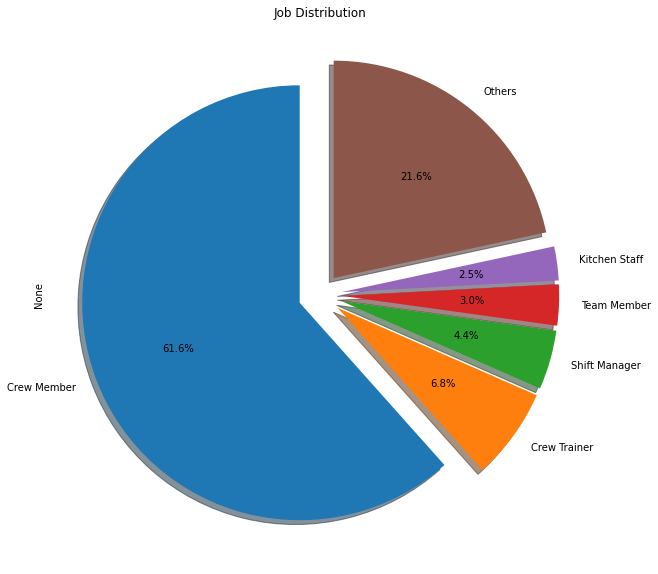

In [13]:
# get top 5 most frequent jobs and Plotting
n = 5
most_freq_jobs = df['job'].value_counts()[:n].index.tolist()
print(most_freq_jobs)

most_freq_jobs_plt = df['job'].value_counts()[:n]

s2 = pd.Series(df['job'].value_counts()[n:].sum(), index = ["Others"])

most_freq_jobs_plt = most_freq_jobs_plt.append(s2)

most_freq_jobs.append("Others")

explode_tuple = tuple((0.1) for i in range(n+1))

most_freq_jobs_plt.plot.pie(y='Most frequent jobs', figsize=(10,10),startangle=90, shadow=True,explode= explode_tuple,labels=most_freq_jobs,  autopct='%1.1f%%')

plt.title("Job Distribution")

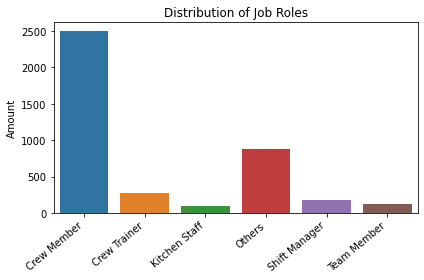

In [14]:
#Plot the job % in the data set
most_freq_jobs_plt.sort_index(inplace=True)
ax = sns.barplot(x=most_freq_jobs_plt.index, y=most_freq_jobs_plt)
ax.set(ylabel="Amount")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Distribution of Job Roles')
plt.tight_layout()
plt.show()

In [15]:
type(most_freq_jobs_plt)

pandas.core.series.Series

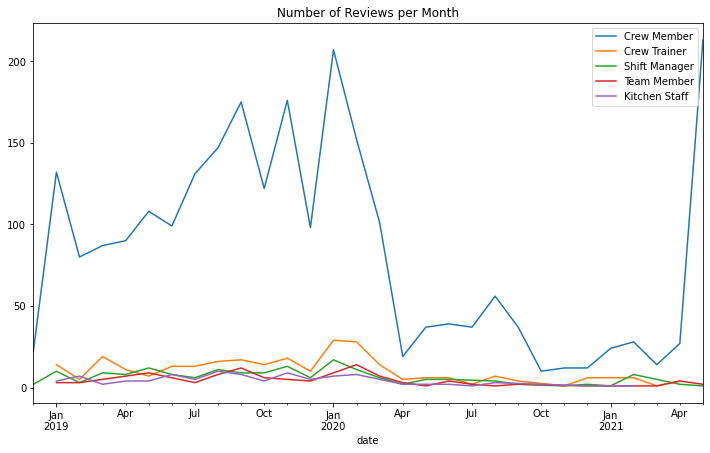

In [16]:
# Reviews over time for top 5 jobs
most_freq_jobs1 = df['job'].value_counts()[:n].index.tolist()

fig, ax = plt.subplots(figsize=(12,7))
for job in most_freq_jobs1:
    df_temp = df[df['job'] == job].copy()
    df_temp['date'] = pd.to_datetime(df_temp['date'].dt.strftime('%Y-%m'))
    #df_temp['date'] = pd.to_datetime(df_temp['date'])
    df_temp = df_temp.groupby(df_temp['date']).size()
    df_temp.plot(label=job, ax=ax)

ax.set_title('Number of Reviews per Month')
ax.legend();

In [17]:
#Remove the review column as it won't be needed
df_cleaned = df.explode(column = 'review_tokenized')
df_cleaned = df_cleaned.drop(columns='review')
df_cleaned = df_cleaned.rename(columns={'review_tokenized':'token'})

In [18]:
# Most words used by type of Job
df_cleaned.groupby(['job','token'])['token'] \
    .count() \
    .reset_index(name='count') \
    .groupby('job') \
    .apply(lambda x: x.sort_values('count', ascending=False).head(5))

job token  count
job                                                            
1st Assistant Manager 137    1st Assistant Manager    to     11
                      154    1st Assistant Manager   you      8
                      4      1st Assistant Manager   and      8
                      135    1st Assistant Manager   the      7
                      52     1st Assistant Manager   for      5
...                                            ...   ...    ...
work at till          34170           work at till  with      2
                      34160           work at till   not      2
                      34141           work at till    am      1
                      34142           work at till    at      1
                      34171           work at till  work      1

[1760 rows x 3 columns]

In [19]:
#Total words used per Job title
df_cleaned.groupby(by='job')['token'].count().sort_values(ascending=False).head(10)

job
Crew Member                   159008
Crew Trainer                   14098
Shift Manager                   9336
Team Member                     5899
Kitchen Staff                   4509
Customer Care Assistant         4483
Customer Service Assistant      2299
Customer Assistant              1672
Sales Assistant                 1019
Staff Member                     972
Name: token, dtype: int64

In [20]:
#Length of reviews by Job
temp_df = pd.DataFrame(df_cleaned.groupby(by =["job", "ID"])["token"].count())
temp_df.reset_index().groupby("job")["token"].agg(['mean']).sort_values("mean",ascending=False).head(10)

,mean
job,
"Salfords, Surrey",300.0
Customer care/cleaner,277.0
Delivery Person,268.0
winsford,262.0
CEL- CUSTOMER EXPERIENCE LEADER /SUPERVISOR,181.0
Delivery Manager & Maintenance Man,180.0
Floor Staff,158.0
Customer Care Assistant/Hospitality Ambassador,153.0
Shift and Recruitment Manager,137.0


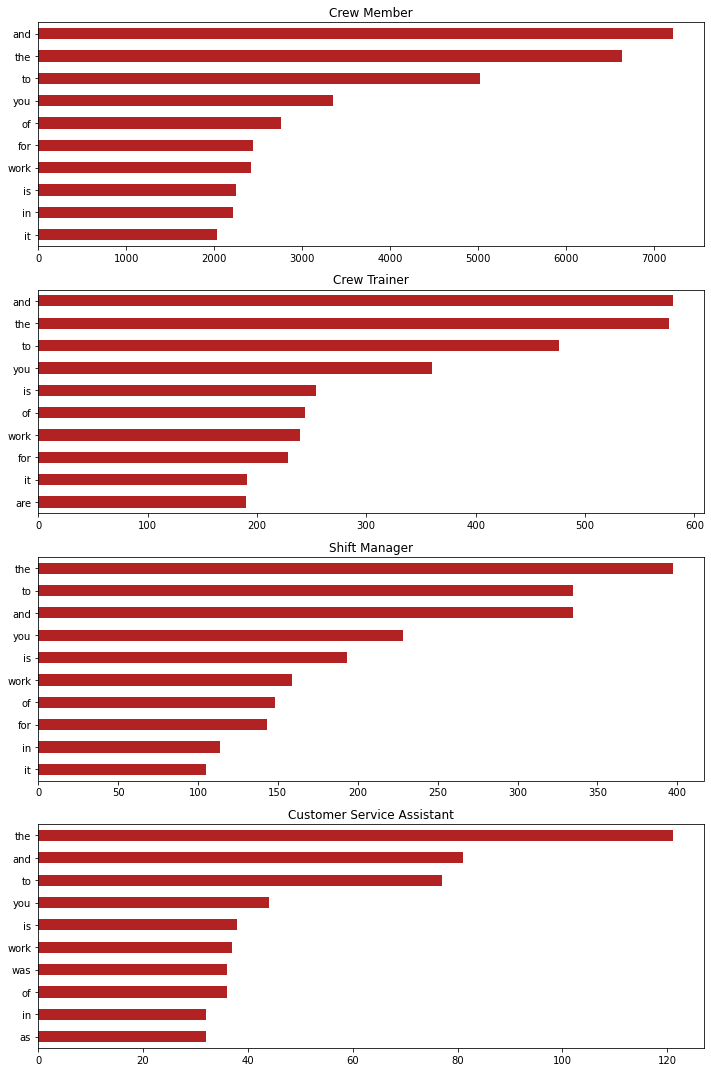

In [21]:
# Top 10 words by job (with stopwords)

fig, axs = plt.subplots(nrows=4, ncols=1,figsize=(10, 15))
for i, job in enumerate(df_cleaned.job.unique()):
    #Added an if statement because i would get out of range
    if i < 4:
        df_temp = df_cleaned[df_cleaned.job == job]
        counts  = df_temp['token'].value_counts(ascending=False).head(10)
        counts.plot(kind='barh', color='firebrick', ax=axs[i])
        axs[i].invert_yaxis()
        axs[i].set_title(job)

fig.tight_layout()


In [22]:
#Stop words removal

stop_words = list(stopwords.words('english'))
print(stop_words)
df_cleaned = df_cleaned[~(df_cleaned["token"].isin(stop_words))]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

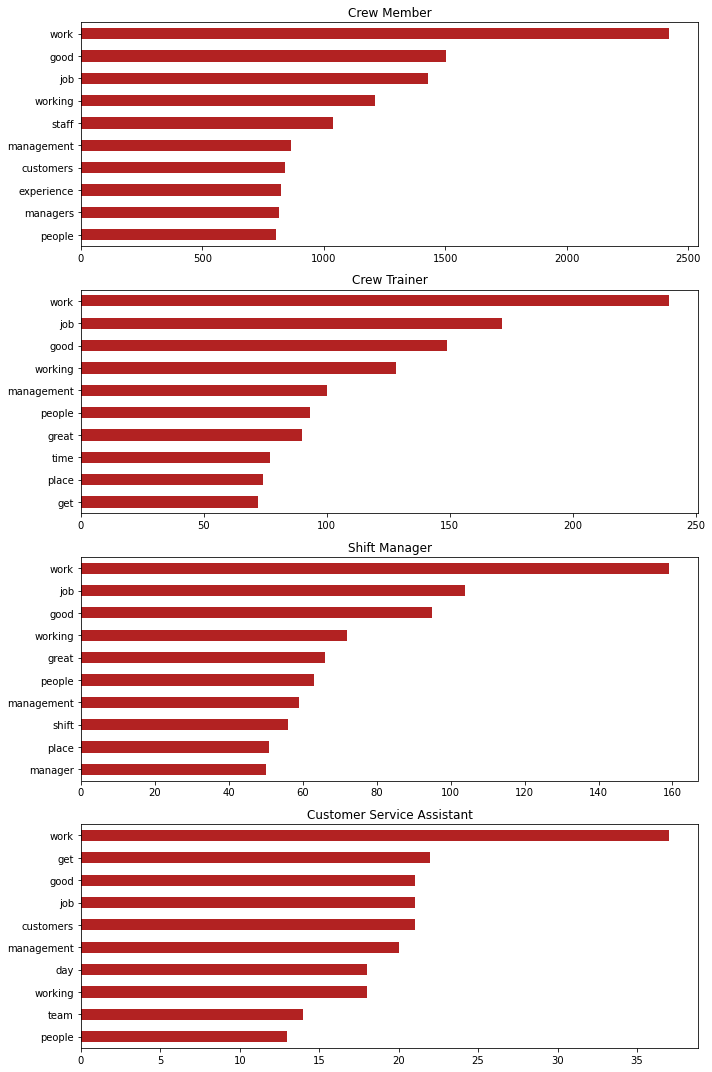

In [23]:
# Top 10 words by job (without stopwords)
fig, axs = plt.subplots(nrows=4, ncols=1,figsize=(10, 15))
for i, job in enumerate(df_cleaned.job.unique()):
    #Added an if statement because i would get out of range
    if i < 4:
        df_temp = df_cleaned[df_cleaned.job == job]
        counts  = df_temp['token'].value_counts(ascending=False).head(10)
        counts.plot(kind='barh', color='firebrick', ax=axs[i])
        axs[i].invert_yaxis()
        axs[i].set_title(job)

fig.tight_layout()


In [24]:
#  term-frequency (tf)
tf = df_cleaned.copy()
# the amount of times a ter, shows in a review
tf = tf.groupby(["ID", "token"])["token"].agg(["count"]).reset_index()
# Column with the amount of terms per review
tf['total_count'] = tf.groupby('ID')['count'].transform(sum)
# Calculate the tf
tf['tf'] = tf["count"] / tf["total_count"]
tf.sort_values(by = "tf").head(10)

,ID,token,count,total_count,tf
100235,3741,college,1,155,0.006452
100251,3741,ever,1,155,0.006452
100253,3741,expected,1,155,0.006452
100255,3741,fairly,1,155,0.006452
100256,3741,felt,1,155,0.006452
100257,3741,first,1,155,0.006452
100258,3741,fit,1,155,0.006452
100259,3741,foot,1,155,0.006452
100260,3741,gate,1,155,0.006452
100263,3741,give,1,155,0.006452


tf.head(20)

### Sentiment Analysis

We're looking to analyze the text of the reviews and check the sentiment by revie and check the evolution over time and also check it by job

In [25]:
#Get lexicon table
lexicon = pd.read_table(
            'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
            names = ['term', 'sentiment']
          )
lexicon.head(10)

,term,sentiment
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2
5,abductions,-2
6,abhor,-3
7,abhorred,-3
8,abhorrent,-3
9,abhors,-3


In [26]:
#Sentiment for each review
review_sentiment = pd.merge(
                            left     = df_cleaned,
                            right    = lexicon,
                            left_on  = "token", 
                            right_on = "term",
                            how      = "inner"
                      )

review_sentiment = review_sentiment.drop(columns = "term")

# Add all the words by job
review_sentiment = review_sentiment[["job","date", "ID", "sentiment"]] \
                      .groupby(["job", "date", "ID"])\
                      .sum().reset_index()
review_sentiment.head()

,job,date,ID,sentiment
0,1st Assistant Manager,2019-06-17,2053,9
1,1st Assistant Manager,2019-08-27,1513,4
2,1st Assistant Manager,2019-12-28,509,4
3,1st Assistant Manager,2020-01-12,388,5
4,1st Assistant Manager,2020-01-19,289,11


In [27]:
#Get Review Sentiment per Job 
def sentiment_profile(dataFrame):
    print(job)
    print("=" * 12)
    print(f"Positive: {round(100 * np.mean(dataFrame.sentiment > 0), 2)}")
    print(f"Neutral  : {round(100 * np.mean(dataFrame.sentiment == 0), 2)}")
    print(f"Negatives: {round(100 * np.mean(dataFrame.sentiment < 0), 2)}")
    print(" ")

df1 = df.copy()

for job, df1 in review_sentiment.groupby(["job","ID"]):
    sentiment_profile(df1)

('1st Assistant Manager', 261)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('1st Assistant Manager', 289)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('1st Assistant Manager', 388)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('1st Assistant Manager', 509)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('1st Assistant Manager', 1513)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('1st Assistant Manager', 2053)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('2nd Assistant Manager', 566)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('2nd Assistant Manager', 813)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('2nd Assistant Manager', 2933)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('AREA LEADER', 689)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('AREA MANAGER', 3092)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Administration Assistant', 592)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Administration Assistant', 3785)
Positive: 100.0
Neutral  : 0.

Positive: 0.0
Neutral  : 100.0
Negatives: 0.0
 
('Crew Member', 125)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 126)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 127)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 130)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 131)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 132)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 134)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 135)
Positive: 0.0
Neutral  : 100.0
Negatives: 0.0
 
('Crew Member', 138)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 139)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 140)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 142)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 143)
Positive: 0.0
Neutral  : 100.0
Negatives: 0.0
 
('Crew Member', 144)
Positive: 100.0
Neutral  : 0.0
Neg

Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 491)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 492)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 494)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 495)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 498)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 499)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 502)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 503)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 504)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 505)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 506)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 507)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 510)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 511)
Positive: 0.0
Neutral  : 100.0
Negatives: 0.0
 
('

 
('Crew Member', 810)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 812)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 814)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 816)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 817)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 818)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 819)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 820)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 821)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 822)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 824)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 827)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 828)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 832)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 833)
Positive: 0

Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1162)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1164)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 1166)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1167)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1171)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1172)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1173)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 1174)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1175)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1176)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 1177)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1178)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1179)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1180)
Positive: 0.0
Neutral  : 0.0
Negativ

Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1488)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1490)
Positive: 0.0
Neutral  : 100.0
Negatives: 0.0
 
('Crew Member', 1491)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 1493)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 1495)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1496)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1497)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1498)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 1499)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1500)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1502)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1505)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1506)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 1511)
Positive: 100.0
Neut

Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1822)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1824)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 1826)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1827)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 1829)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1830)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1831)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 1832)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 1833)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1835)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 1837)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1838)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1839)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 1842)
Positive: 0.0
Neutral  : 0.0
Negativ

Negatives: 0.0
 
('Crew Member', 2179)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2180)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2181)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2183)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2184)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 2185)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 2187)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2189)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2191)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2199)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 2202)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2203)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2205)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 2207)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('C

Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2486)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2487)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2488)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2489)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2490)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2492)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2493)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 2494)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2496)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2497)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 2498)
Positive: 0.0
Neutral  : 100.0
Negatives: 0.0
 
('Crew Member', 2499)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 2503)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2505)
Positive: 100.0
Neutral  : 0.0
Negat

Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2805)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2806)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2807)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2808)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2809)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2811)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2813)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2814)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 2815)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2816)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2817)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 2818)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 2819)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 2821)
Positive: 100.0
Neut

Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3056)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3058)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3059)
Positive: 0.0
Neutral  : 100.0
Negatives: 0.0
 
('Crew Member', 3060)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3061)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3062)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3063)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3065)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3066)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 3069)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 3070)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3071)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3072)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 3075)
Positive: 100.0
Neut

Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3406)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3408)
Positive: 0.0
Neutral  : 100.0
Negatives: 0.0
 
('Crew Member', 3410)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3411)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3412)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3413)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3417)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3418)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3421)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3422)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 3423)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 3426)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3427)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3428)
Positive: 100.0
Neut

Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3715)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3716)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 3717)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 3720)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3722)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3723)
Positive: 0.0
Neutral  : 100.0
Negatives: 0.0
 
('Crew Member', 3727)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3729)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3730)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 3731)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3733)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3734)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Member', 3735)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Member', 3736)
Positive: 0.0
Neutral  : 0.0
Negativ

Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 15)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 32)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 39)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Trainer', 44)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 48)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Crew Trainer', 61)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 72)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 77)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 87)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 88)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 96)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 108)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 109)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 117)
Positive: 100.0
Neutral  : 0.0


Negatives: 100.0
 
('Crew Trainer', 2621)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 2623)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 2629)
Positive: 0.0
Neutral  : 100.0
Negatives: 0.0
 
('Crew Trainer', 2645)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 2654)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 2662)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 2684)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 2695)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 2711)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 2720)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 2724)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 2736)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 2747)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Crew Trainer', 2778)
Positive: 0.0
Neutral  : 0.0
Negati

Negatives: 100.0
 
('Customer Care Assistant', 1851)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Customer Care Assistant', 1874)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Customer Care Assistant', 1939)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Customer Care Assistant', 1970)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Customer Care Assistant', 1987)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Customer Care Assistant', 2002)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Customer Care Assistant', 2020)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Customer Care Assistant', 2126)
Positive: 0.0
Neutral  : 100.0
Negatives: 0.0
 
('Customer Care Assistant', 2206)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Customer Care Assistant', 2309)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Customer Care Assistant', 2313)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Customer Care Assistant', 2647)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0

Negatives: 0.0
 
('Dining Room Assistant', 3858)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Dining area', 1159)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Drive thru worker / cashier', 1264)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Dundee', 1938)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Duties taken assisting to customers', 2733)
Positive: 0.0
Neutral  : 100.0
Negatives: 0.0
 
('Employed', 2157)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
("Employee at McDonald's", 2381)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Everything', 2986)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Excellent customer service', 3119)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Eye green', 267)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('FLOOR MANAGER', 522)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('First Assistant Manager', 771)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('First Assistant Manager', 3135)
Positive: 100.0
Neutral  : 0.0
Ne

Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Manager', 1249)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Manager', 1330)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Manager', 1445)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Manager', 1587)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Manager', 1621)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Manager', 1786)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Manager', 2536)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Manager', 2828)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Manager', 2971)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Manager', 3256)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Manager', 3328)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Manager', 3376)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Manager', 3404)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Manager Assistant', 2832)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Manchester', 201

Negatives: 0.0
 
('Shift Manager', 1509)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Shift Manager', 1518)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Shift Manager', 1563)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Shift Manager', 1569)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Shift Manager', 1573)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Shift Manager', 1586)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Shift Manager', 1594)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Shift Manager', 1644)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Shift Manager', 1707)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Shift Manager', 1713)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Shift Manager', 1732)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Shift Manager', 1747)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Shift Manager', 1801)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Shift Manager', 1885)
Positive: 0.0
Neutral  

 
('Team Member', 612)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Team Member', 631)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Team Member', 719)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Team Member', 811)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Team Member', 830)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Team Member', 867)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Team Member', 948)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Team Member', 997)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Team Member', 1070)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Team Member', 1099)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Team Member', 1118)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Team Member', 1135)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Team Member', 1138)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('Team Member', 1184)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('Team Member', 1203)
Posi

('shift manager', 2696)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('shift manager', 2887)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('shift manager', 3659)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('stock and delivery', 2632)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('team member', 1958)
Positive: 0.0
Neutral  : 100.0
Negatives: 0.0
 
('team member', 2022)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('team member', 2413)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('team member', 2872)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('team member', 3177)
Positive: 0.0
Neutral  : 0.0
Negatives: 100.0
 
('toilet cleaner', 657)
Positive: 0.0
Neutral  : 100.0
Negatives: 0.0
 
('train them and lead areas when necessary', 3136)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('wharehouse operative', 2704)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('while there I progressed up to area leader', 534)
Positive: 100.0
Neutral  : 0.0
Negatives: 0.0
 
('winsf

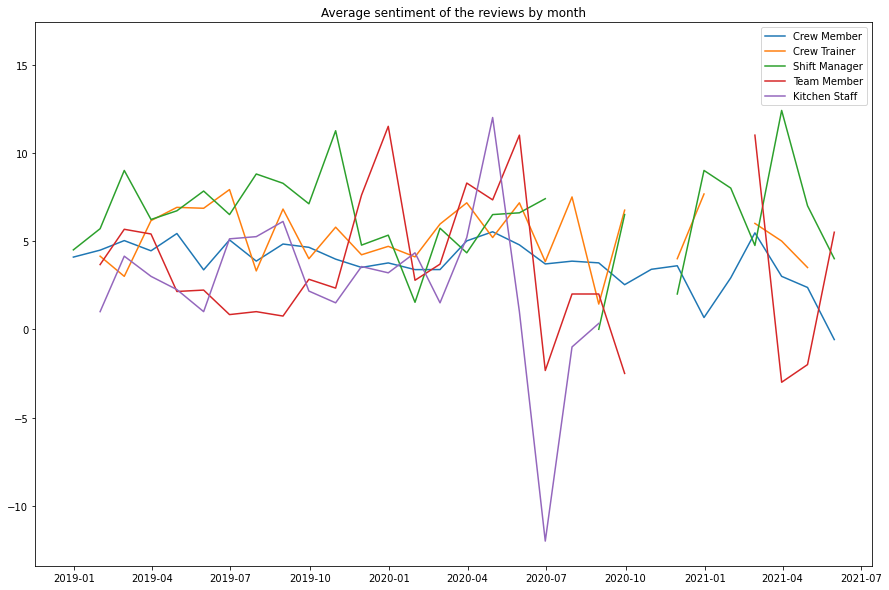

In [116]:
#Plotting sentiment
fig, ax = plt.subplots(figsize=(15, 10)) 
for job in most_freq_jobs:
    df_plt = review_sentiment[review_sentiment.job == job].copy()
    df_plt['date'] =pd.to_datetime(df_plt['date'])
    df_plt = df_plt.set_index("date")
    df_plt = df_plt[['sentiment']].resample('1M').mean()
    ax.plot(df_plt.index, df_plt.sentiment, label=job)

ax.set_title("Average sentiment of the reviews by month")
ax.legend();

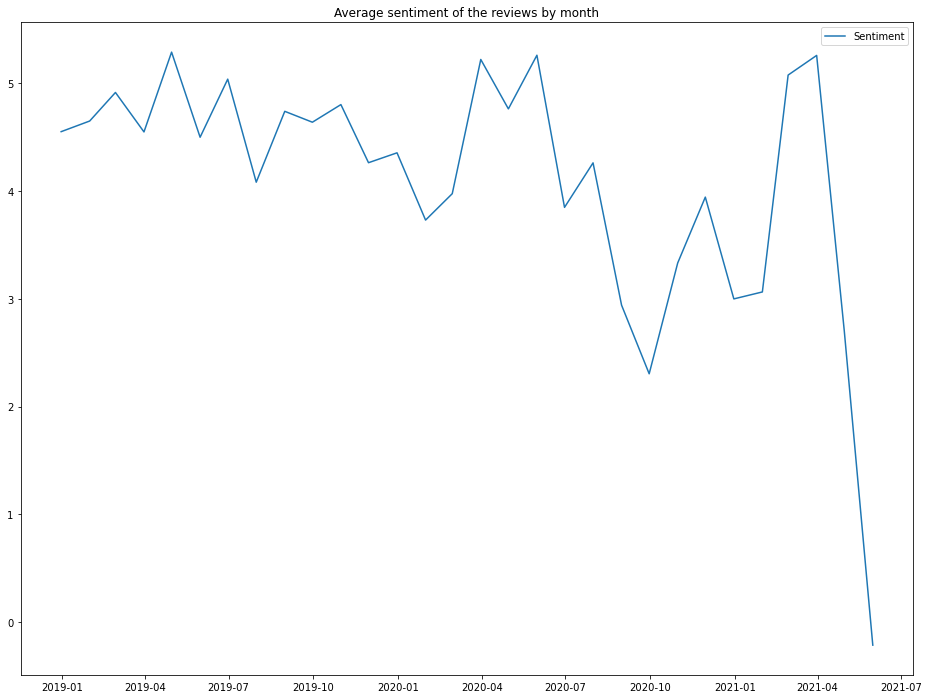

In [29]:
#Plotting sentiment Overall
fig, ax = plt.subplots(figsize=(16, 12)) 

df_plt = review_sentiment.copy()
df_plt['date'] =pd.to_datetime(df_plt['date'])
df_plt = df_plt.set_index("date")
df_plt = df_plt[['sentiment']].resample('1M').mean()
ax.plot(df_plt.index, df_plt.sentiment, label="Sentiment")

ax.set_title("Average sentiment of the reviews by month")
ax.legend(loc = "upper right");

## Frequency Analysis

In [30]:
# Check the columns present in th tf
df.columns.values

array(['ID', 'review title', 'review', 'pros', 'cons', 'date', 'job',
       'location', 'rating', 'review title_tokenized', 'review_tokenized',
       'pros_tokenized', 'cons_tokenized'], dtype=object)

In [31]:
# Create a dataframe with only the review
processedReviews =  pd.DataFrame(data=df.review_tokenized, index=df.index, columns=['review_tokenized']) 
processedReviews

,review_tokenized
0,"[i’ve, been, working, at, mcdonald’s, for, yea..."
1,"[working, here, helped, me, gain, confidence, ..."
2,"[workplace, is, high, pressure, and, high, dem..."
3,"[enjoy, working, at, mcdonald, for, the, sort,..."
4,"[very, fast, paced, place, to, work, you, are,..."
...,...
4048,"[worked, at, mcdonald’s, for, few, years, but,..."
4049,"[it, is, great, place, to, work, very, friendl..."
4050,"[was, thoroughly, happy, with, working, for, m..."
4051,"[although, did, enjoy, working, at, mcdonald’s..."


In [32]:
# Remove stopwords and re-explore results
stop_words = set(stopwords.words('english'))
processedReviews = processedReviews['review_tokenized'].apply(lambda x: [item for item in x if item not in stop_words])
processedReviews = pd.DataFrame(data= processedReviews, columns=['review_tokenized'])
processedReviews.head(10)

,review_tokenized
0,"[i’ve, working, mcdonald’s, year, months, year..."
1,"[working, helped, gain, confidence, talking, p..."
2,"[workplace, high, pressure, high, demand, mana..."
3,"[enjoy, working, mcdonald, sort, period, time,..."
4,"[fast, paced, place, work, able, gain, lot, sk..."
5,"[enjoyed, working, promised, least, hours, rec..."
6,"[offer, flexible, working, hours, vary, full, ..."
7,"[working, mcdonald’s, brilliant, part, time, j..."
8,"[busy, days, variety, job, roles, periods, hig..."
9,"[it’s, really, good, place, job, matter, age, ..."


In [33]:
# Stemm texts function
def stemming(words):
    procText = []
    for w in (words[:]):
        stemmed_word = [snowball.stem(x) for x in (w[:])]
        procText.append(stemmed_word)
    return procText

In [34]:
# Do stemming
snowball = SnowballStemmer("english")
# Create a new column for stemm words
processedReviews['StemmedWords'] = stemming(processedReviews['review_tokenized'])

In [35]:
# Compute terms frequency distribution
from nltk.probability import FreqDist
fdist = FreqDist()
for review in processedReviews.review_tokenized:
  for term in review:
    fdist[term]+=1

In [36]:
# Transform results to a sorted dataframe
df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index.name = 'Term'
df_fdist = df_fdist.sort_values(by='Frequency', ascending=False)

In [37]:
# Top 15
df_fdist.head(15)

,Frequency
Term,
work,3667
good,2215
job,2209
working,1857
staff,1398
management,1309
people,1286
place,1142
customers,1132


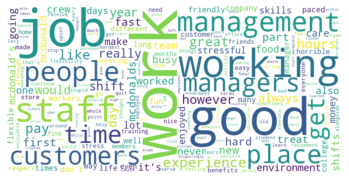

In [38]:
# Create a Word Cloud
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', contour_color='white')
wordcloud.generate_from_frequencies(frequencies=df_fdist.Frequency)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [39]:
# Calculate frequency distributions of the stemmed words
fdist = FreqDist()
for review in processedReviews.StemmedWords:
  for term in review:
    fdist[term]+=1

# Create the sorted dataframe and sort it
df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index.name = 'Term'
df_fdist = df_fdist.sort_values(by='Frequency', ascending=False)

In [40]:
# Remove the stopwords
df_fdist = df_fdist[~df_fdist.index.isin(stop_words)] 

(-0.5, 799.5, 399.5, -0.5)

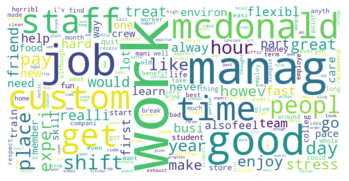

In [41]:
# Plot a new wordcloud with the stemmed words
wordcloud = WordCloud(width=800, height=400, background_color='white', contour_color='white')
wordcloud.generate_from_frequencies(frequencies=df_fdist.Frequency)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

In [42]:
processedReviews.columns.values

array(['review_tokenized', 'StemmedWords'], dtype=object)

In [43]:
sentences = processedReviews["StemmedWords"]
counts = nltk.FreqDist()   # or nltk.FreqDist()
for sent in sentences:
     X =counts.update(nltk.ngrams(sent, 1))
counts

FreqDist({('work',): 6071, ('manag',): 2876, ('job',): 2370, ('good',): 2215, ('mcdonald',): 1515, ('custom',): 1445, ('staff',): 1405, ('time',): 1401, ('get',): 1312, ('peopl',): 1309, ...})

In [44]:
#Dataframe With the most used terms
N_gram = pd.DataFrame.from_dict(counts, orient='index')
N_gram.columns = ['Frequency']
N_gram.index.name = 'Term'
N_gram.reset_index(level=0, inplace=True)
N_gram["Frequency"] =N_gram["Frequency"].apply(pd.to_numeric)
N_gram["Term"] = N_gram["Term"].apply(lambda x: "".join(x))
N_gram.head(20)

,Term,Frequency
0,i'v,249
1,work,6071
2,mcdonald,1515
3,year,906
4,month,348
5,old,261
6,colleg,364
7,student,366
8,like,935
9,good,2215


Text(0.5, 1.0, 'Most frequent 1 gram')

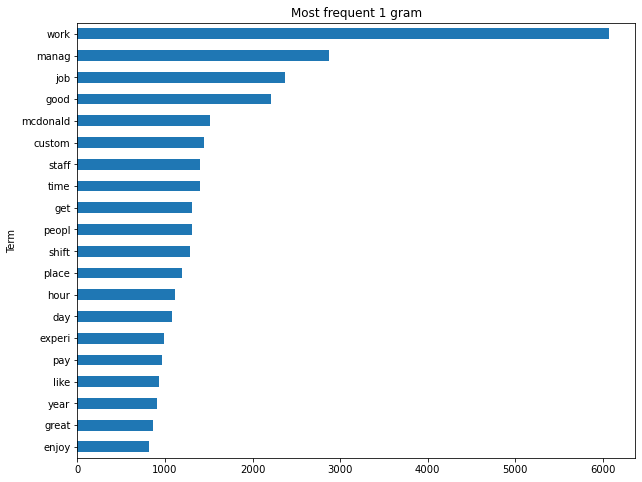

In [117]:
#plot most used terms
N_gram_plt = N_gram.sort_values(["Frequency"], ascending=False)
N_gram_plt = N_gram_plt.head(20)
N_gram_plt.plot(kind='barh',figsize=(10,8) , x='Term', legend=None).invert_yaxis()
plt.title("Most frequent 1 gram")

In [46]:
#Get the frequency count of 2 n-grams
sentences = processedReviews["StemmedWords"]
counts2 = nltk.FreqDist()
for sent in sentences:
     X =counts2.update(nltk.ngrams(sent, 2))
counts2

FreqDist({('work', 'mcdonald'): 722, ('place', 'work'): 688, ('fast', 'pace'): 405, ('good', 'place'): 368, ('part', 'job'): 256, ('year', 'old'): 243, ('good', 'pay'): 239, ('staff', 'manag'): 238, ('manag', 'good'): 237, ('mcdonald', 'year'): 230, ...})

In [47]:
# Transform counts2 into a df
N_gram2 = pd.DataFrame.from_dict(counts2, orient='index')
N_gram2.columns = ['Frequency']
N_gram2.index.name = 'Term'
N_gram2.reset_index(level=0, inplace=True)
N_gram2["Frequency"] =N_gram2["Frequency"].apply(pd.to_numeric)
N_gram2["Term"] = N_gram2["Term"].apply(lambda x: " ".join(x))
N_gram2.head(20)

,Term,Frequency
0,i'v work,205
1,work mcdonald,722
2,mcdonald year,230
3,year month,198
4,month year,195
5,year old,243
6,old colleg,194
7,colleg student,198
8,student like,195
9,like good,197


Text(0.5, 1.0, 'Most frequent 2 gram')

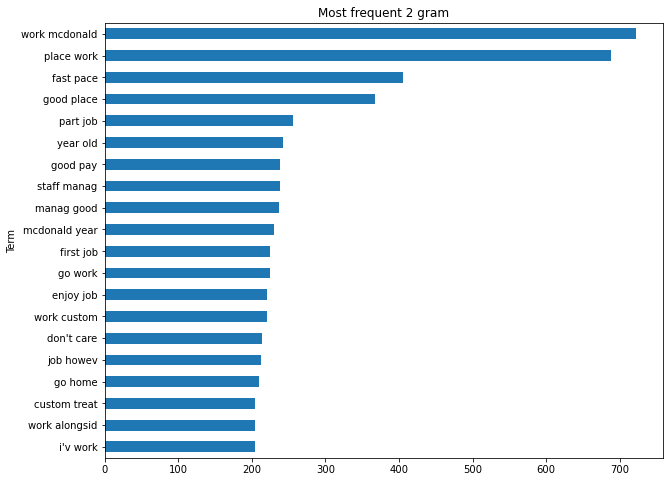

In [113]:
# Plot 2 n-grams
N_gram_plt2 = N_gram2.sort_values(["Frequency"], ascending=False)
N_gram_plt2 = N_gram_plt2.head(20)
N_gram_plt2.plot(kind='barh',figsize=(10,8) , x='Term', legend=None).invert_yaxis()
plt.title("Most frequent 2 gram")

In [49]:
# Frequency for 3 n-grams
sentences = processedReviews["StemmedWords"]
counts3 = nltk.FreqDist()
for sent in sentences:
     X =counts3.update(nltk.ngrams(sent, 3))
counts3

FreqDist({('good', 'place', 'work'): 301, ('work', 'mcdonald', 'year'): 227, ("i'v", 'work', 'mcdonald'): 196, ('month', 'year', 'old'): 194, ('year', 'old', 'colleg'): 194, ('work', 'custom', 'treat'): 194, ('custom', 'treat', 'disgust'): 194, ('way', 'treat', 'manag'): 194, ('staff', 'manag', 'good'): 194, ('experi', 'good', 'pay'): 194, ...})

Text(0.5, 1.0, 'Most frequent 3 gram')

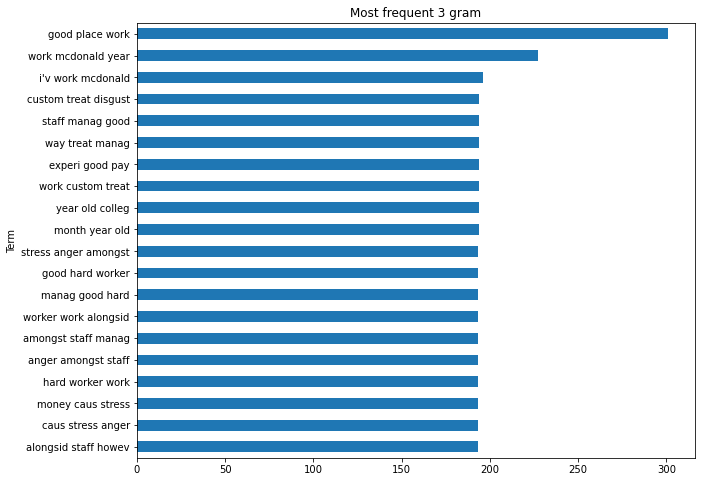

In [112]:
N_gram3 = pd.DataFrame.from_dict(counts3, orient='index')
N_gram3.columns = ['Frequency']
N_gram3.index.name = 'Term'
N_gram3.reset_index(level=0, inplace=True)
N_gram3["Frequency"] =N_gram3["Frequency"].apply(pd.to_numeric)
N_gram3["Term"] = N_gram3["Term"].apply(lambda x: " ".join(x))
N_gram_plt3 = N_gram3.sort_values(["Frequency"], ascending=False)
N_gram_plt3 = N_gram_plt3.head(20)
N_gram_plt3.plot(kind='barh',figsize=(10,8) , x='Term', legend=None).invert_yaxis()
plt.title("Most frequent 3 gram")

In [51]:
df['job'].value_counts()[:5].index.tolist()

['Crew Member',
 'Crew Trainer',
 'Shift Manager',
 'Team Member',
 'Kitchen Staff']

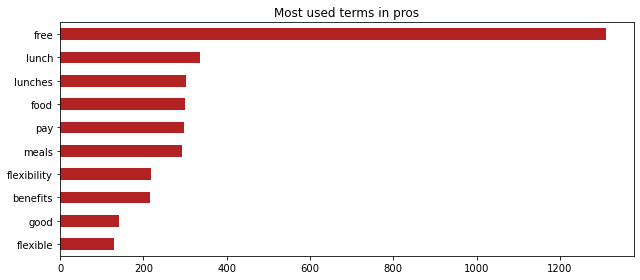

In [52]:
#Remove the pros column as it won't be needed
df_cleaned_pro = df.explode(column = 'pros_tokenized')
df_cleaned_pro = df_cleaned_pro.drop(columns='pros')
df_cleaned_pro = df_cleaned_pro.rename(columns={'pros_tokenized':'token'})

#Stop words removal
df_cleaned_pro = df_cleaned_pro[~(df_cleaned_pro["token"].isin(stop_words))]


# Top 10 words in Pro Column (without stopwords)
fig, axs = plt.subplots(figsize=(9, 4))

df_temp = df_cleaned_pro
counts  = df_temp['token'].value_counts(ascending=False).head(10)
counts.plot(kind='barh', color='firebrick', ax=axs)
axs.invert_yaxis()
axs.set_title("Most used terms in pros")

fig.tight_layout()

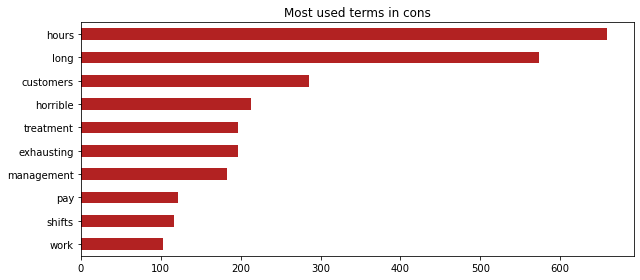

In [53]:
#Remove the cons column as it won't be needed
df_cleaned_cons = df.explode(column = 'cons_tokenized')
df_cleaned_cons = df_cleaned_cons.drop(columns='cons')
df_cleaned_cons = df_cleaned_cons.rename(columns={'cons_tokenized':'token'})

#Stop words removal
stop_words = list(stopwords.words('english'))
df_cleaned_cons = df_cleaned_cons[~(df_cleaned_cons["token"].isin(stop_words))]


# Top 10 words in Pro Column (without stopwords)
fig, axs = plt.subplots(figsize=(9, 4))

df_temp = df_cleaned_cons
counts  = df_temp['token'].value_counts(ascending=False).head(10)
counts.plot(kind='barh', color='firebrick', ax=axs)
axs.invert_yaxis()
axs.set_title("Most used terms in cons")

fig.tight_layout()

In [54]:
# Create a dataframe with only the review pros
processedpros =  pd.DataFrame(data=df.pros_tokenized, index=df.index, columns=['pros_tokenized']) 
processedpros.dropna(inplace = True)

# Remove stopwords and re-explore results
stop_words = set(stopwords.words('english'))
processedpros = processedpros['pros_tokenized'].apply(lambda x: [item for item in x if item not in stop_words])
processedpros = pd.DataFrame(data= processedpros, columns=['pros_tokenized'])

# Do stemming
processedpros['StemmedWords'] = stemming(processedpros['pros_tokenized'])

processedpros


,pros_tokenized,StemmedWords
0,"[free, meals, benefits, pay, flexibility]","[free, meal, benefit, pay, flexibl]"
10,"[pay, way, good]","[pay, way, good]"
21,"[free, meals, benefits, pay, flexibility]","[free, meal, benefit, pay, flexibl]"
22,"[free, lunches]","[free, lunch]"
28,"[fast, pace, work, sets, future, fast, pace, w...","[fast, pace, work, set, futur, fast, pace, wor..."
...,...,...
4045,"[free, lunches]","[free, lunch]"
4046,"[free, meal]","[free, meal]"
4047,"[free, lunch]","[free, lunch]"
4048,"[free, break, allowance, secure, job]","[free, break, allow, secur, job]"


In [102]:
#Create a function to create n-grams(should've been used earlier)
def n_gramer(df,n_gram):
    sentences = df["StemmedWords"]
    counts = nltk.FreqDist()
    for sent in sentences:
         X =counts.update(nltk.ngrams(sent, n_gram))

    N_gram = pd.DataFrame.from_dict(counts, orient='index')
    N_gram.columns = ['Frequency']
    N_gram.index.name = 'Term'
    N_gram.reset_index(level=0, inplace=True)
    N_gram["Frequency"] =N_gram["Frequency"].apply(pd.to_numeric)
    N_gram["Term"] = N_gram["Term"].apply(lambda x: " ".join(x))
    N_gram_plt = N_gram.sort_values(["Frequency"], ascending=False).head(20)
    N_gram_plt.plot(kind='barh',figsize=(10,8) , x='Term', legend=None).invert_yaxis()
    plt.title(f"Most frequent {n_gram} gram")

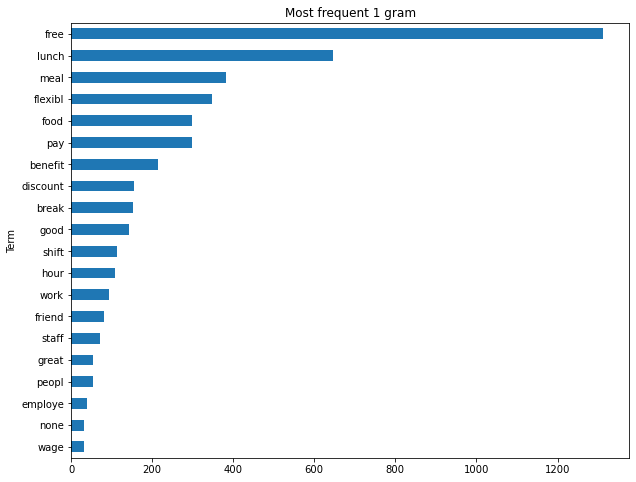

In [103]:
#Pros 1 n-gram
n_gramer(processedpros,1)

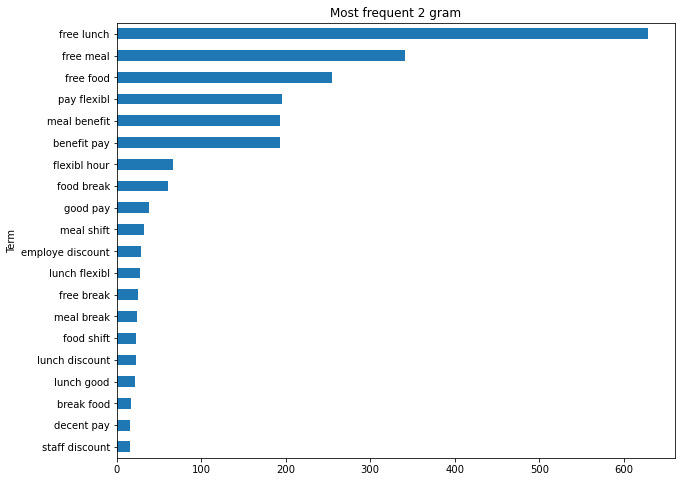

In [104]:
#Pros 2 n-gram
n_gramer(processedpros,2)

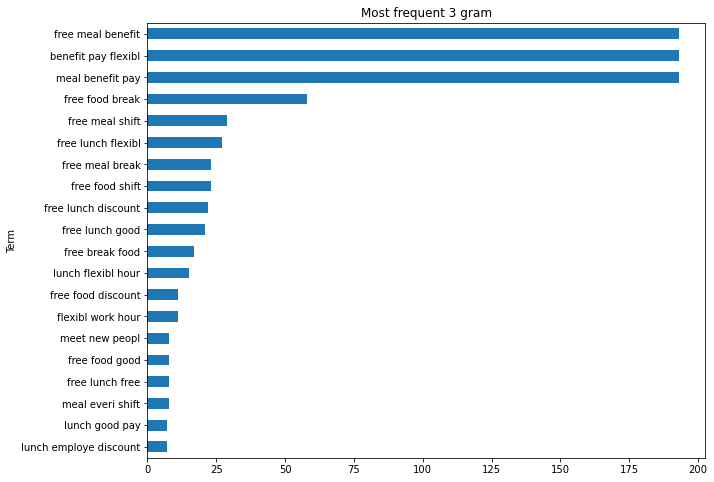

In [105]:
#Pros 3 n-gram
n_gramer(processedpros,3)

In [59]:
# Create a dataframe with only the review cons
processedcons =  pd.DataFrame(data=df.cons_tokenized, index=df.index, columns=['cons_tokenized']) 
processedcons.dropna(inplace = True)

# Remove stopwords and re-explore results
stop_words = set(stopwords.words('english'))
processedcons = processedcons['cons_tokenized'].apply(lambda x: [item for item in x if item not in stop_words])
processedcons = pd.DataFrame(data= processedcons, columns=['cons_tokenized'])

# Do stemming
processedcons['StemmedWords'] = stemming(processedcons['cons_tokenized'])

processedcons

,cons_tokenized,StemmedWords
0,"[long, hours, exhausting, horrible, treatment,...","[long, hour, exhaust, horribl, treatment, custom]"
10,"[management, rude]","[manag, rude]"
21,"[long, hours, exhausting, horrible, treatment,...","[long, hour, exhaust, horribl, treatment, custom]"
22,"[long, hours]","[long, hour]"
28,"[unfair, treatment, toward, crew, members, ext...","[unfair, treatment, toward, crew, member, extr..."
...,...,...
4045,"[evening, shifts]","[even, shift]"
4046,[everything],[everyth]
4047,"[won’t, want, leave]","[won't, want, leav]"
4048,"[favouritism, bullying, time, christmas]","[favourit, bulli, time, christma]"


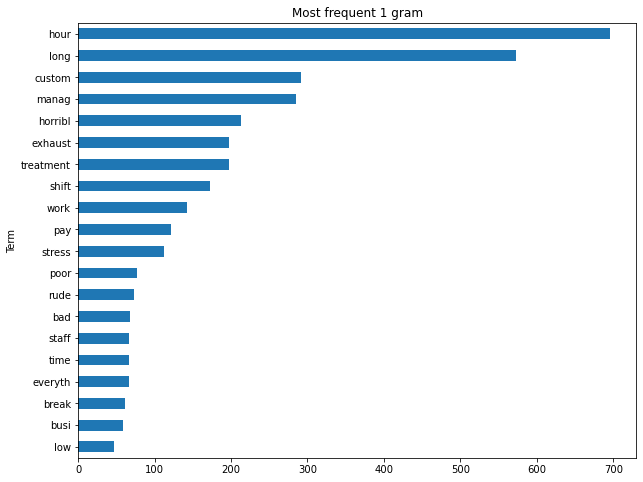

In [106]:
#Cons 1 n-gram
n_gramer(processedcons,1)

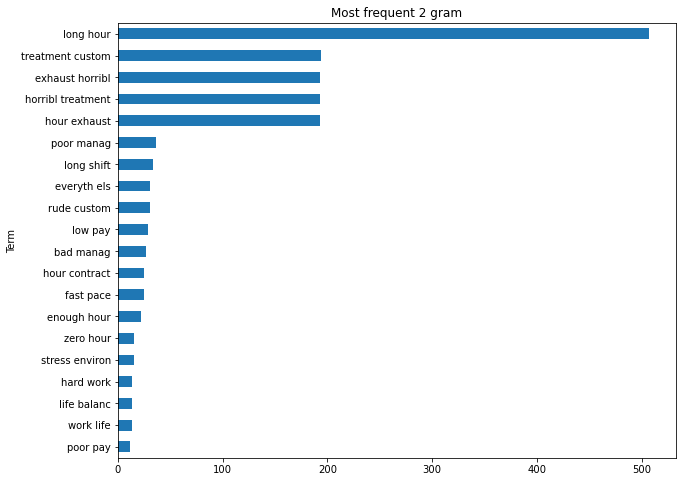

In [107]:
#Cons 2 n-gram
n_gramer(processedcons,2)

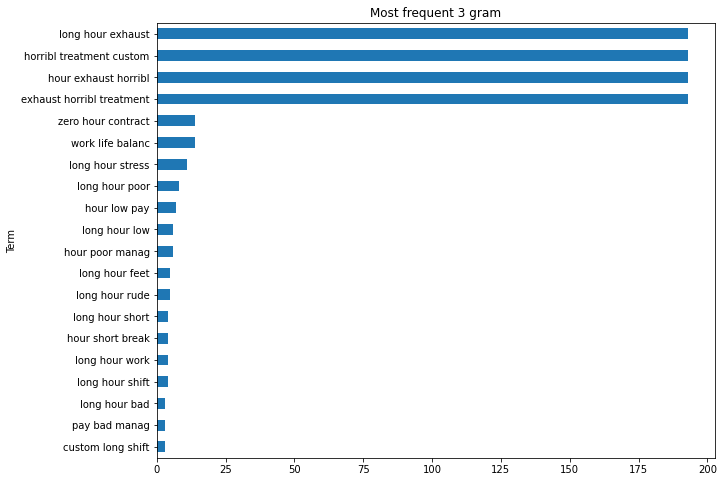

In [108]:
#Cons 3 n-gram
n_gramer(processedcons,3)

## Review Analysis/ Comparison

In this section we're diving deeper on the analysis and actually looking at the data. 
#### To do:
- Check the sentiment present in reviews that have at least on of the top 10 most used words
- Compare the Average rating with the sentiment and see if it actually makes sense
- Along the lines of the previous point check if there are suspicious reviews with contrary rating and sentiment
- Compare the sentiment among job titles
- Check the correlation amongst reviews and see if the subjects talked about are related



In [63]:
#Filter the reviews that do not stand in the top 5
top_5 = df['job'].value_counts()[:5].index.tolist()
df_top5 = df[df["job"].isin(top_5)]
df_top5

,ID,review title,review,pros,cons,date,job,location,rating,review title_tokenized,review_tokenized,pros_tokenized,cons_tokenized
0,0,Customers are disgustingly rude,I’ve been working at McDonald’s for a year and...,"Free meals, benefits, pay, flexibility","Long hours, exhausting, horrible treatment fro...",2021-05-14,Crew Member,Telford,3.0,"[customers, are, disgustingly, rude]","[i’ve, been, working, at, mcdonald’s, for, yea...","[free, meals, benefits, pay, flexibility]","[long, hours, exhausting, horrible, treatment,..."
1,1,"Productive, good to learn new skills and devel...",Working here helped me gain confidence when ta...,NaN,NaN,2020-02-19,Crew Member,Dorchester,4.0,"[productive, good, to, learn, new, skills, and...","[working, here, helped, me, gain, confidence, ...",NaN,NaN
2,2,Workplace,Workplace is high pressure and high demand. Ma...,NaN,NaN,2020-02-19,Crew Trainer,"Hazel Grove, Greater Manchester",1.0,[workplace],"[workplace, is, high, pressure, and, high, dem...",NaN,NaN
3,3,McDonald's merthyr,Enjoy working at Mcdonald for the sort period ...,NaN,NaN,2020-02-19,Crew Member,Merthyr Tydfil,4.0,"[mcdonald, merthyr]","[enjoy, working, at, mcdonald, for, the, sort,...",NaN,NaN
4,4,Good first time job,A very fast paced place to work. You are able ...,NaN,NaN,2020-02-18,Crew Member,Crawley,5.0,"[good, first, time, job]","[very, fast, paced, place, to, work, you, are,...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4045,4045,Very busy place,"Very busy place, a lot to learn.My day startin...",Free lunches,Evening shifts,2020-11-29,Crew Member,"Croydon, Greater London",4.0,"[very, busy, place]","[very, busy, place, lot, to, learn, my, day, s...","[free, lunches]","[evening, shifts]"
4046,4046,Absolutely poor,"Good for students to make some money, other th...",Free meal,Everything,2020-11-28,Crew Member,"Banbridge, County Down",1.0,"[absolutely, poor]","[good, for, students, to, make, some, money, o...","[free, meal]",[everything]
4048,4048,Could be better,Worked at McDonald’s for a few years but found...,"Free break allowance, secure job","Favouritism, bullying, no time off over Christmas",2020-11-25,Crew Member,"Blackwood, Caerphilly",3.0,"[could, be, better]","[worked, at, mcdonald’s, for, few, years, but,...","[free, break, allowance, secure, job]","[favouritism, bullying, no, time, off, over, c..."
4051,4051,Overworked and tiring.,Although I did enjoy working at McDonald’s som...,Long breaks (45 mins),You are treated like a number,2020-11-20,Crew Member,"Cannock, Staffordshire",3.0,"[overworked, and, tiring]","[although, did, enjoy, working, at, mcdonald’s...","[long, breaks, mins]","[you, are, treated, like, number]"


In [64]:
# Average rating by job
df_top5["rating"] = pd.to_numeric(df_top5["rating"])
df_top5.groupby(['job']).agg({'rating':"mean"}).reset_index().rename(columns={'job':'Job Title','rating':'Average Rating'})

,Job Title,Average Rating
0,Crew Member,3.189406
1,Crew Trainer,3.463768
2,Kitchen Staff,3.088235
3,Shift Manager,3.488764
4,Team Member,3.032520


In [65]:
#Get the sentiment in a DF to analyze the reviews and sentiments
df_top5= pd.merge(
                            left     = df_top5,
                            right    = review_sentiment,
                            left_on  = "ID", 
                            right_on = "ID",
                            how      = "inner",
                            suffixes=('', '_y')
                      )
df_top5.drop(df_top5.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
df_top5

,ID,review title,review,pros,cons,date,job,location,rating,review title_tokenized,review_tokenized,pros_tokenized,cons_tokenized,sentiment
0,0,Customers are disgustingly rude,I’ve been working at McDonald’s for a year and...,"Free meals, benefits, pay, flexibility","Long hours, exhausting, horrible treatment fro...",2021-05-14,Crew Member,Telford,3.0,"[customers, are, disgustingly, rude]","[i’ve, been, working, at, mcdonald’s, for, yea...","[free, meals, benefits, pay, flexibility]","[long, hours, exhausting, horrible, treatment,...",-1
1,1,"Productive, good to learn new skills and devel...",Working here helped me gain confidence when ta...,NaN,NaN,2020-02-19,Crew Member,Dorchester,4.0,"[productive, good, to, learn, new, skills, and...","[working, here, helped, me, gain, confidence, ...",NaN,NaN,12
2,2,Workplace,Workplace is high pressure and high demand. Ma...,NaN,NaN,2020-02-19,Crew Trainer,"Hazel Grove, Greater Manchester",1.0,[workplace],"[workplace, is, high, pressure, and, high, dem...",NaN,NaN,4
3,3,McDonald's merthyr,Enjoy working at Mcdonald for the sort period ...,NaN,NaN,2020-02-19,Crew Member,Merthyr Tydfil,4.0,"[mcdonald, merthyr]","[enjoy, working, at, mcdonald, for, the, sort,...",NaN,NaN,3
4,4,Good first time job,A very fast paced place to work. You are able ...,NaN,NaN,2020-02-18,Crew Member,Crawley,5.0,"[good, first, time, job]","[very, fast, paced, place, to, work, you, are,...",NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3096,4043,"Didn't Hate the Job, Just the Management","The job itself is hard work, but can be reward...",Free lunches,"Long hours, never appreciated.",2020-11-30,Crew Member,Bedfordshire,3.0,"[didn, hate, the, job, just, the, management]","[the, job, itself, is, hard, work, but, can, b...","[free, lunches]","[long, hours, never, appreciated]",1
3097,4046,Absolutely poor,"Good for students to make some money, other th...",Free meal,Everything,2020-11-28,Crew Member,"Banbridge, County Down",1.0,"[absolutely, poor]","[good, for, students, to, make, some, money, o...","[free, meal]",[everything],4
3098,4048,Could be better,Worked at McDonald’s for a few years but found...,"Free break allowance, secure job","Favouritism, bullying, no time off over Christmas",2020-11-25,Crew Member,"Blackwood, Caerphilly",3.0,"[could, be, better]","[worked, at, mcdonald’s, for, few, years, but,...","[free, break, allowance, secure, job]","[favouritism, bullying, no, time, off, over, c...",5
3099,4051,Overworked and tiring.,Although I did enjoy working at McDonald’s som...,Long breaks (45 mins),You are treated like a number,2020-11-20,Crew Member,"Cannock, Staffordshire",3.0,"[overworked, and, tiring]","[although, did, enjoy, working, at, mcdonald’s...","[long, breaks, mins]","[you, are, treated, like, number]",-1


In [66]:
#Average Rating and Sentiment per job
df_top5.groupby(['job']).agg({'rating':"mean","sentiment":"mean"}).reset_index()\
                        .rename(columns={'job':'Job Title','rating':'Average Rating',"sentiment":"Average Sentiment"})

,Job Title,Average Rating,Average Sentiment
0,Crew Member,3.182712,3.686604
1,Crew Trainer,3.457565,5.328413
2,Kitchen Staff,3.117021,3.308511
3,Shift Manager,3.474286,6.182857
4,Team Member,3.041667,3.425000


In [67]:
#Check for reviews that have high rating but low sentiment
high_low = df_top5.loc[(df_top5["rating"]>=4.0)&(df_top5["sentiment"]<2)]
high_low

,ID,review title,review,pros,cons,date,job,location,rating,review title_tokenized,review_tokenized,pros_tokenized,cons_tokenized,sentiment
19,20,fun,its ok depends which manager your on shift wit...,NaN,NaN,2020-02-17,Crew Member,London,4.0,[fun],"[its, ok, depends, which, manager, your, on, s...",NaN,NaN,-3
30,35,Alright,Although I did find it difficult to work there...,NaN,NaN,2020-02-15,Crew Member,United Kingdom,4.0,[alright],"[although, did, find, it, difficult, to, work,...",NaN,NaN,0
31,36,Enjoyable,I really enjoyed my position as a crew member ...,NaN,NaN,2020-02-15,Crew Member,Colchester,4.0,[enjoyable],"[really, enjoyed, my, position, as, crew, memb...",NaN,NaN,-2
33,38,McDonald’s,You were never bored working there was always ...,NaN,NaN,2020-02-14,Crew Member,"Colchester, Essex",5.0,[mcdonald’s],"[you, were, never, bored, working, there, was,...",NaN,NaN,-2
40,48,Nice place if you fit in,As its a franchise they dont pay as well as co...,NaN,NaN,2020-02-13,Crew Trainer,Hartlepool,4.0,"[nice, place, if, you, fit, in]","[as, its, franchise, they, dont, pay, as, well...",NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,3909,Fun but stressful,It is a fast paced job. You have to be prepare...,"Free meal on break, discounts online","Long hours, mixed shifts, don't always finish ...",2021-04-11,Crew Trainer,"Bradford, West Yorkshire",5.0,"[fun, but, stressful]","[it, is, fast, paced, job, you, have, to, be, ...","[free, meal, on, break, discounts, online]","[long, hours, mixed, shifts, don, always, fini...",-3
3001,3929,Room for improvement and progress,I started when I left school and went from fro...,"Free food, good discount","Irregular hours, management",2021-03-27,Shift Manager,Burntwood,4.0,"[room, for, improvement, and, progress]","[started, when, left, school, and, went, from,...","[free, food, good, discount]","[irregular, hours, management]",0
3051,3989,fun,its ok depends which manager your on shift wit...,NaN,NaN,2020-02-17,Crew Member,London,4.0,[fun],"[its, ok, depends, which, manager, your, on, s...",NaN,NaN,-3
3058,3998,Alright improvements could be beneficial,"Good job, but management can be extremely toxi...",Free meal on work,Long hours management,2021-05-12,Crew Member,"Glasgow, Glasgow",4.0,"[alright, improvements, could, be, beneficial]","[good, job, but, management, can, be, extremel...","[free, meal, on, work]","[long, hours, management]",-2


In [134]:
high_low["review"][31]

"I really enjoyed my position as a crew member with McDonalds the only downside to working in the store i did was the fact that the business manager was a unprofessional and judgemental phony,_x000D_i feel i worked well within the group i was in but failed probation because the business manager didn't like me everyone whom i worked with also disagreed with the final outcome of my probation period."

In [68]:
#Check for reviews that have low rating but high sentiment
low_high = df_top5.loc[(df_top5["rating"]<3.0)&(df_top5["sentiment"]>3)]
low_high

,ID,review title,review,pros,cons,date,job,location,rating,review title_tokenized,review_tokenized,pros_tokenized,cons_tokenized,sentiment
2,2,Workplace,Workplace is high pressure and high demand. Ma...,NaN,NaN,2020-02-19,Crew Trainer,"Hazel Grove, Greater Manchester",1.0,[workplace],"[workplace, is, high, pressure, and, high, dem...",NaN,NaN,4
42,50,I am not happy here,The worst thing is the managers. From the top ...,Free lunch,"Kitchen is nightmare, awful to stuck in one area",2020-02-12,Crew Member,England,1.0,"[am, not, happy, here]","[the, worst, thing, is, the, managers, from, t...","[free, lunch]","[kitchen, is, nightmare, awful, to, stuck, in,...",4
46,54,Would not recomend,The best part about mcdonalds is the people yo...,NaN,NaN,2020-02-12,Crew Member,Manchester,2.0,"[would, not, recomend]","[the, best, part, about, mcdonalds, is, the, p...",NaN,NaN,9
51,61,Ok first job,"It's an ok first job but nothing more, use McD...",NaN,NaN,2020-02-11,Crew Trainer,"Cambridge City Centre, Cambridgeshire",2.0,"[ok, first, job]","[it, an, ok, first, job, but, nothing, more, u...",NaN,NaN,4
55,68,depressing,"managers not helpful 95% of the time, not enou...","free food for break, employee discounts","managers are only focussed on targets, not eno...",2020-02-10,Crew Member,"Tweed, Northumberland",2.0,[depressing],"[managers, not, helpful, of, the, time, not, e...","[free, food, for, break, employee, discounts]","[managers, are, only, focussed, on, targets, n...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3034,3971,Workplace,Workplace is high pressure and high demand. Ma...,NaN,NaN,2020-02-19,Crew Trainer,"Hazel Grove, Greater Manchester",1.0,[workplace],"[workplace, is, high, pressure, and, high, dem...",NaN,NaN,4
3054,3993,Not great,"For what you get paid, the stress you get is n...",Nothing,Eveeything,2021-05-14,Shift Manager,Merthy4,1.0,"[not, great]","[for, what, you, get, paid, the, stress, you, ...",[nothing],[eveeything],4
3088,4033,Stressful,Stressful workplace and caused a lot of mental...,NaN,NaN,2020-12-16,Crew Trainer,Dundee,1.0,[stressful],"[stressful, workplace, and, caused, lot, of, m...",NaN,NaN,5
3095,4042,Ok to start,The start was ok. But you'll only move up if y...,Some of the Staff make it worth it,"Customers, Management, unappreciated, cliquey",2020-12-01,Crew Trainer,Bognor Regis,1.0,"[ok, to, start]","[the, start, was, ok, but, you, ll, only, move...","[some, of, the, staff, make, it, worth, it]","[customers, management, unappreciated, cliquey]",10


In [133]:
low_high["review"][42]

'The worst thing is the managers. From the top one to the lower one. In my branch they are always avoiding hard jobs. Hardly ever seen them working hard. Favouritism as well. On one occasion we had some additional managers from other branches. They really showed the difference and were super hardworking and friendly and praised hard team work, unlike ours, who only pick on you.'

In [69]:
# Print the results
print("Reviews in Top5:",len(df_top5.index))
print("Reviews with High Rating/Low Sentiment:",len(high_low))
print("Reviews with Low Rating/High Sentiment:",len(low_high))

Reviews in Top5: 3101
Reviews with High Rating/Low Sentiment: 170
Reviews with Low Rating/High Sentiment: 183


In [70]:
amount_left = len(df_top5.index)-len(high_low)-len(low_high)
d = {'Category': ["Consistent Reviews", "High Rating/Low Sentiment","Low Rating/High Sentiment"], 'Amount': [amount_left, len(high_low),len(low_high)]}
amount_df = pd.DataFrame(data = d)
amount_df["Amount"] = pd.to_numeric(amount_df["Amount"])
amount_df

,Category,Amount
0,Consistent Reviews,2748
1,High Rating/Low Sentiment,170
2,Low Rating/High Sentiment,183


In [71]:
#Check the sentiment in the top 10 words used
top10_list = N_gram_plt["Term"].tolist()
top10_list = top10_list[:10]
top10_list

['work',
 'manag',
 'job',
 'good',
 'mcdonald',
 'custom',
 'staff',
 'time',
 'get',
 'peopl']

In [72]:
#Merge dfs to get the stemmed words instead of doing it all over again
df_top5used = pd.merge(
                            left     = df_top5,
                            right    = processedReviews,
                            left_on  = "ID",
                            right_index=True,
                            how      = "inner",
                            suffixes=('', '_y')
                      )
df_top5used.drop(df_top5used.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
df_top5used

,ID,review title,review,pros,cons,date,job,location,rating,review title_tokenized,review_tokenized,pros_tokenized,cons_tokenized,sentiment,StemmedWords
0,0,Customers are disgustingly rude,I’ve been working at McDonald’s for a year and...,"Free meals, benefits, pay, flexibility","Long hours, exhausting, horrible treatment fro...",2021-05-14,Crew Member,Telford,3.0,"[customers, are, disgustingly, rude]","[i’ve, been, working, at, mcdonald’s, for, yea...","[free, meals, benefits, pay, flexibility]","[long, hours, exhausting, horrible, treatment,...",-1,"[i'v, work, mcdonald, year, month, year, old, ..."
1,1,"Productive, good to learn new skills and devel...",Working here helped me gain confidence when ta...,NaN,NaN,2020-02-19,Crew Member,Dorchester,4.0,"[productive, good, to, learn, new, skills, and...","[working, here, helped, me, gain, confidence, ...",NaN,NaN,12,"[work, help, gain, confid, talk, peopl, allow,..."
2,2,Workplace,Workplace is high pressure and high demand. Ma...,NaN,NaN,2020-02-19,Crew Trainer,"Hazel Grove, Greater Manchester",1.0,[workplace],"[workplace, is, high, pressure, and, high, dem...",NaN,NaN,4,"[workplac, high, pressur, high, demand, manag,..."
3,3,McDonald's merthyr,Enjoy working at Mcdonald for the sort period ...,NaN,NaN,2020-02-19,Crew Member,Merthyr Tydfil,4.0,"[mcdonald, merthyr]","[enjoy, working, at, mcdonald, for, the, sort,...",NaN,NaN,3,"[enjoy, work, mcdonald, sort, period, time, cr..."
4,4,Good first time job,A very fast paced place to work. You are able ...,NaN,NaN,2020-02-18,Crew Member,Crawley,5.0,"[good, first, time, job]","[very, fast, paced, place, to, work, you, are,...",NaN,NaN,2,"[fast, pace, place, work, abl, gain, lot, skil..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3096,4043,"Didn't Hate the Job, Just the Management","The job itself is hard work, but can be reward...",Free lunches,"Long hours, never appreciated.",2020-11-30,Crew Member,Bedfordshire,3.0,"[didn, hate, the, job, just, the, management]","[the, job, itself, is, hard, work, but, can, b...","[free, lunches]","[long, hours, never, appreciated]",1,"[job, hard, work, reward, enjoy, howev, feel, ..."
3097,4046,Absolutely poor,"Good for students to make some money, other th...",Free meal,Everything,2020-11-28,Crew Member,"Banbridge, County Down",1.0,"[absolutely, poor]","[good, for, students, to, make, some, money, o...","[free, meal]",[everything],4,"[good, student, make, money, run, hill, work, ..."
3098,4048,Could be better,Worked at McDonald’s for a few years but found...,"Free break allowance, secure job","Favouritism, bullying, no time off over Christmas",2020-11-25,Crew Member,"Blackwood, Caerphilly",3.0,"[could, be, better]","[worked, at, mcdonald’s, for, few, years, but,...","[free, break, allowance, secure, job]","[favouritism, bullying, no, time, off, over, c...",5,"[work, mcdonald, year, found, store, clicki, f..."
3099,4051,Overworked and tiring.,Although I did enjoy working at McDonald’s som...,Long breaks (45 mins),You are treated like a number,2020-11-20,Crew Member,"Cannock, Staffordshire",3.0,"[overworked, and, tiring]","[although, did, enjoy, working, at, mcdonald’s...","[long, breaks, mins]","[you, are, treated, like, number]",-1,"[although, enjoy, work, mcdonald, day, shift, ..."


In [73]:
#Transform StemmedWords into string
df_top5used1 = df_top5used.copy()
df_top5used1['StemmedWords'] = [','.join(map(str, l)) for l in df_top5used1['StemmedWords']]
#df_top5used1 = df_top5used1[~df_top5used1["StemmedWords"].isin(top10_list)]
df_top5used1

,ID,review title,review,pros,cons,date,job,location,rating,review title_tokenized,review_tokenized,pros_tokenized,cons_tokenized,sentiment,StemmedWords
0,0,Customers are disgustingly rude,I’ve been working at McDonald’s for a year and...,"Free meals, benefits, pay, flexibility","Long hours, exhausting, horrible treatment fro...",2021-05-14,Crew Member,Telford,3.0,"[customers, are, disgustingly, rude]","[i’ve, been, working, at, mcdonald’s, for, yea...","[free, meals, benefits, pay, flexibility]","[long, hours, exhausting, horrible, treatment,...",-1,"i'v,work,mcdonald,year,month,year,old,colleg,s..."
1,1,"Productive, good to learn new skills and devel...",Working here helped me gain confidence when ta...,NaN,NaN,2020-02-19,Crew Member,Dorchester,4.0,"[productive, good, to, learn, new, skills, and...","[working, here, helped, me, gain, confidence, ...",NaN,NaN,12,"work,help,gain,confid,talk,peopl,allow,learn,n..."
2,2,Workplace,Workplace is high pressure and high demand. Ma...,NaN,NaN,2020-02-19,Crew Trainer,"Hazel Grove, Greater Manchester",1.0,[workplace],"[workplace, is, high, pressure, and, high, dem...",NaN,NaN,4,"workplac,high,pressur,high,demand,manag,train,..."
3,3,McDonald's merthyr,Enjoy working at Mcdonald for the sort period ...,NaN,NaN,2020-02-19,Crew Member,Merthyr Tydfil,4.0,"[mcdonald, merthyr]","[enjoy, working, at, mcdonald, for, the, sort,...",NaN,NaN,3,"enjoy,work,mcdonald,sort,period,time,crew,memb..."
4,4,Good first time job,A very fast paced place to work. You are able ...,NaN,NaN,2020-02-18,Crew Member,Crawley,5.0,"[good, first, time, job]","[very, fast, paced, place, to, work, you, are,...",NaN,NaN,2,"fast,pace,place,work,abl,gain,lot,skill,custom..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3096,4043,"Didn't Hate the Job, Just the Management","The job itself is hard work, but can be reward...",Free lunches,"Long hours, never appreciated.",2020-11-30,Crew Member,Bedfordshire,3.0,"[didn, hate, the, job, just, the, management]","[the, job, itself, is, hard, work, but, can, b...","[free, lunches]","[long, hours, never, appreciated]",1,"job,hard,work,reward,enjoy,howev,feel,like,und..."
3097,4046,Absolutely poor,"Good for students to make some money, other th...",Free meal,Everything,2020-11-28,Crew Member,"Banbridge, County Down",1.0,"[absolutely, poor]","[good, for, students, to, make, some, money, o...","[free, meal]",[everything],4,"good,student,make,money,run,hill,work,compani,..."
3098,4048,Could be better,Worked at McDonald’s for a few years but found...,"Free break allowance, secure job","Favouritism, bullying, no time off over Christmas",2020-11-25,Crew Member,"Blackwood, Caerphilly",3.0,"[could, be, better]","[worked, at, mcdonald’s, for, few, years, but,...","[free, break, allowance, secure, job]","[favouritism, bullying, no, time, off, over, c...",5,"work,mcdonald,year,found,store,clicki,found,ma..."
3099,4051,Overworked and tiring.,Although I did enjoy working at McDonald’s som...,Long breaks (45 mins),You are treated like a number,2020-11-20,Crew Member,"Cannock, Staffordshire",3.0,"[overworked, and, tiring]","[although, did, enjoy, working, at, mcdonald’s...","[long, breaks, mins]","[you, are, treated, like, number]",-1,"although,enjoy,work,mcdonald,day,shift,would,l..."


In [74]:
#Filter out reviews that don't have the 10 most used terms
df_top5usedy = df_top5used1[df_top5used1.StemmedWords.str.contains('|'.join(top10_list))]
df_top5usedy

,ID,review title,review,pros,cons,date,job,location,rating,review title_tokenized,review_tokenized,pros_tokenized,cons_tokenized,sentiment,StemmedWords
0,0,Customers are disgustingly rude,I’ve been working at McDonald’s for a year and...,"Free meals, benefits, pay, flexibility","Long hours, exhausting, horrible treatment fro...",2021-05-14,Crew Member,Telford,3.0,"[customers, are, disgustingly, rude]","[i’ve, been, working, at, mcdonald’s, for, yea...","[free, meals, benefits, pay, flexibility]","[long, hours, exhausting, horrible, treatment,...",-1,"i'v,work,mcdonald,year,month,year,old,colleg,s..."
1,1,"Productive, good to learn new skills and devel...",Working here helped me gain confidence when ta...,NaN,NaN,2020-02-19,Crew Member,Dorchester,4.0,"[productive, good, to, learn, new, skills, and...","[working, here, helped, me, gain, confidence, ...",NaN,NaN,12,"work,help,gain,confid,talk,peopl,allow,learn,n..."
2,2,Workplace,Workplace is high pressure and high demand. Ma...,NaN,NaN,2020-02-19,Crew Trainer,"Hazel Grove, Greater Manchester",1.0,[workplace],"[workplace, is, high, pressure, and, high, dem...",NaN,NaN,4,"workplac,high,pressur,high,demand,manag,train,..."
3,3,McDonald's merthyr,Enjoy working at Mcdonald for the sort period ...,NaN,NaN,2020-02-19,Crew Member,Merthyr Tydfil,4.0,"[mcdonald, merthyr]","[enjoy, working, at, mcdonald, for, the, sort,...",NaN,NaN,3,"enjoy,work,mcdonald,sort,period,time,crew,memb..."
4,4,Good first time job,A very fast paced place to work. You are able ...,NaN,NaN,2020-02-18,Crew Member,Crawley,5.0,"[good, first, time, job]","[very, fast, paced, place, to, work, you, are,...",NaN,NaN,2,"fast,pace,place,work,abl,gain,lot,skill,custom..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3096,4043,"Didn't Hate the Job, Just the Management","The job itself is hard work, but can be reward...",Free lunches,"Long hours, never appreciated.",2020-11-30,Crew Member,Bedfordshire,3.0,"[didn, hate, the, job, just, the, management]","[the, job, itself, is, hard, work, but, can, b...","[free, lunches]","[long, hours, never, appreciated]",1,"job,hard,work,reward,enjoy,howev,feel,like,und..."
3097,4046,Absolutely poor,"Good for students to make some money, other th...",Free meal,Everything,2020-11-28,Crew Member,"Banbridge, County Down",1.0,"[absolutely, poor]","[good, for, students, to, make, some, money, o...","[free, meal]",[everything],4,"good,student,make,money,run,hill,work,compani,..."
3098,4048,Could be better,Worked at McDonald’s for a few years but found...,"Free break allowance, secure job","Favouritism, bullying, no time off over Christmas",2020-11-25,Crew Member,"Blackwood, Caerphilly",3.0,"[could, be, better]","[worked, at, mcdonald’s, for, few, years, but,...","[free, break, allowance, secure, job]","[favouritism, bullying, no, time, off, over, c...",5,"work,mcdonald,year,found,store,clicki,found,ma..."
3099,4051,Overworked and tiring.,Although I did enjoy working at McDonald’s som...,Long breaks (45 mins),You are treated like a number,2020-11-20,Crew Member,"Cannock, Staffordshire",3.0,"[overworked, and, tiring]","[although, did, enjoy, working, at, mcdonald’s...","[long, breaks, mins]","[you, are, treated, like, number]",-1,"although,enjoy,work,mcdonald,day,shift,would,l..."


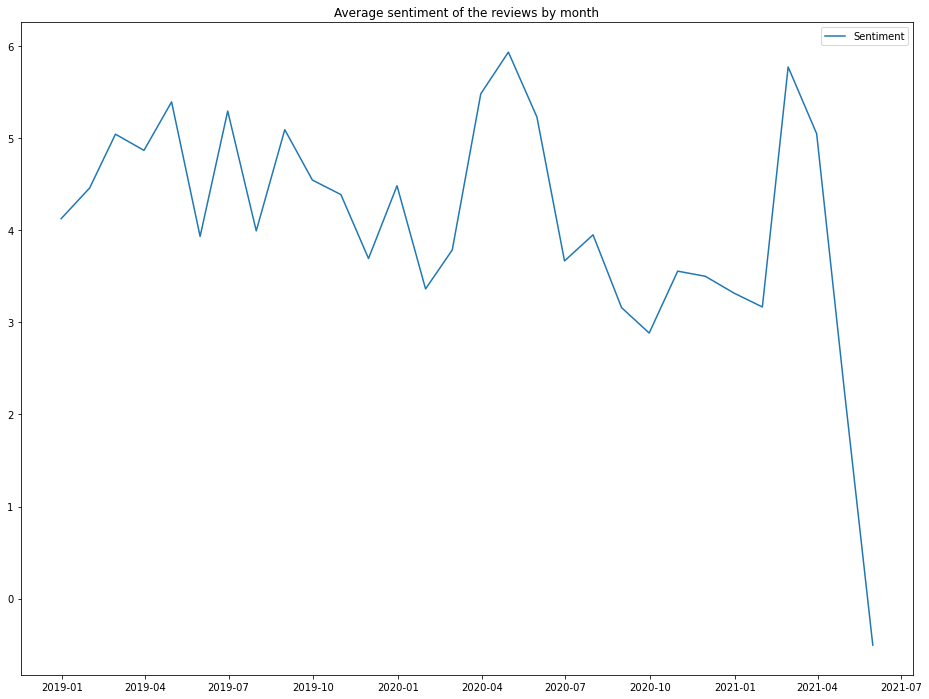

In [75]:
#Plotting sentiment Overall for the reviews that used the top 10 most used words
fig, ax = plt.subplots(figsize=(16, 12)) 

df_plt = df_top5usedy.copy()
df_plt['date'] =pd.to_datetime(df_plt['date'])
df_plt = df_plt.set_index("date")
df_plt = df_plt[['sentiment']].resample('1M').mean()
ax.plot(df_plt.index, df_plt.sentiment, label="Sentiment")

ax.set_title("Average sentiment of the reviews by month")
ax.legend(loc = "upper right");

In [76]:
#Average review and sentiment before removing reviews
df_top5.groupby(['job']).agg({'rating':"mean","sentiment":"mean"}).reset_index()\
                        .rename(columns={'job':'Job Title','rating':'Average Rating',"sentiment":"Average Sentiment"})

,Job Title,Average Rating,Average Sentiment
0,Crew Member,3.182712,3.686604
1,Crew Trainer,3.457565,5.328413
2,Kitchen Staff,3.117021,3.308511
3,Shift Manager,3.474286,6.182857
4,Team Member,3.041667,3.425000


In [77]:
#Average review and sentiment after removing reviews
df_top5usedy.groupby(['job']).agg({'rating':"mean","sentiment":"mean"}).reset_index()\
                        .rename(columns={'job':'Job Title','rating':'Average Rating',"sentiment":"Average Sentiment"})

,Job Title,Average Rating,Average Sentiment
0,Crew Member,3.187655,3.716653
1,Crew Trainer,3.458955,5.309701
2,Kitchen Staff,3.123596,3.483146
3,Shift Manager,3.473988,6.236994
4,Team Member,3.058824,3.529412


In [78]:
#Get the job titles available
lx = df_top5usedy['job'].value_counts().index.tolist()
lx

['Crew Member',
 'Crew Trainer',
 'Shift Manager',
 'Team Member',
 'Kitchen Staff']

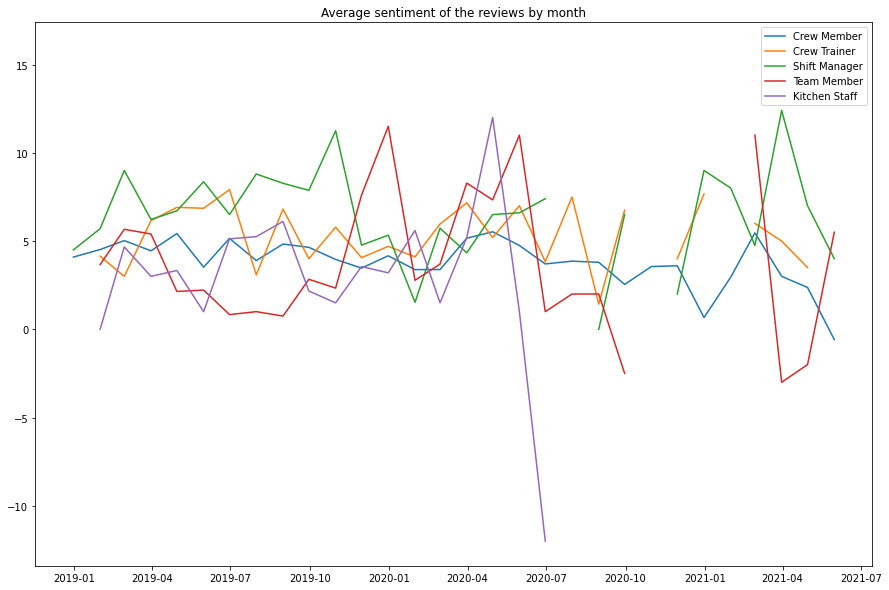

In [79]:
#Plotting sentiment per job title after removing
fig, ax = plt.subplots(figsize=(15, 10)) 
for job in lx:
    df_plt = df_top5usedy[df_top5usedy.job == job].copy()
    df_plt['date'] =pd.to_datetime(df_plt['date'])
    df_plt = df_plt.set_index("date")
    df_plt = df_plt[['sentiment']].resample('1M').mean()
    ax.plot(df_plt.index, df_plt.sentiment, label=job)

ax.set_title("Average sentiment of the reviews by month")
ax.legend();

### Clustering Segment

Since we're comparing reviews we'll analyze them by clustering using 2 methods that are normally used and see the differences that come up. Hopefully these can support the results that showed up earlier and maybe bring some new insights

In [80]:
#Importing packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.cm as cm
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [81]:
# Turning the "StemmedWords" column into a list
rev_k = df_top5usedy["StemmedWords"].tolist()
rev_k

["i'v,work,mcdonald,year,month,year,old,colleg,student,like,good,place,work,term,pay,benefit,flexibl,experi,first,employ,enjoy,job,howev,year,notic,feel,exhaust,upset,mere,thought,go,work,custom,treat,disgust,ounc,respect,ruin,whole,experi,find,go,home,tear,way,treat,manag,never,anyth,stop,head,offic,continu,introduc,new,stupid,idea,uber,eat,click,serv,bring,money,caus,stress,anger,amongst,staff,manag,good,hard,worker,work,alongsid,staff,howev,lazi,realli,don't,care,it,legal,oblig,although,appreci,experi,good,pay,receiv,point,count,day,quit,horribl,custom,that,plain,truth",
 'work,help,gain,confid,talk,peopl,allow,learn,new,skill,could,use,similar,work,industri,major,peopl,work,help,friend,provid,help,need',
 'workplac,high,pressur,high,demand,manag,train,proper,know,manag,crew,neglect,staff,mani,young,first,job,hardwork,dedic,stress,given,compani,reward,wage,pittanc,relat,work,given,crew,part,time,job,need,work,progress,life,viabl,career,rout,benefit,flexibl,avail,workplac,cultur,staf

In [82]:
# Trying out a simple cluster method to see the results
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(rev_k)


true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 manag
 work
 shift
 hour
 job
 staff
 time
 peopl
 like
 mcdonald
Cluster 1:
 year
 experi
 treat
 good
 howev
 pay
 work
 custom
 staff
 ounc
Cluster 2:
 work
 custom
 fast
 learn
 pace
 job
 day
 skill
 team
 mcdonald
Cluster 3:
 great
 work
 friend
 help
 peopl
 fun
 job
 mcdonald
 place
 alway
Cluster 4:
 good
 work
 job
 place
 time
 flexibl
 pay
 hour
 peopl
 manag



Clustering is an unsupervised ML technique and we're using the the MiniBatchKmeans that uses a random set of data each time
it is ran. The toughest challenge using Kmeans is choosing the K but there's a usually method that is the elbow graph that
assists us a lot as it tells us at what number of clusters there's a point of diminishing returns.


In [84]:
# Transforming text into feature vectors so it can be used as an estimator
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(rev_k)
text = tfidf.transform(rev_k)

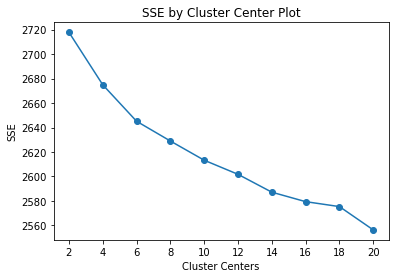

In [85]:
# Plotting the elbow graph with our dataset
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 20)

In [86]:
# Setting up the number of clusters
clusters = MiniBatchKMeans(n_clusters=16, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

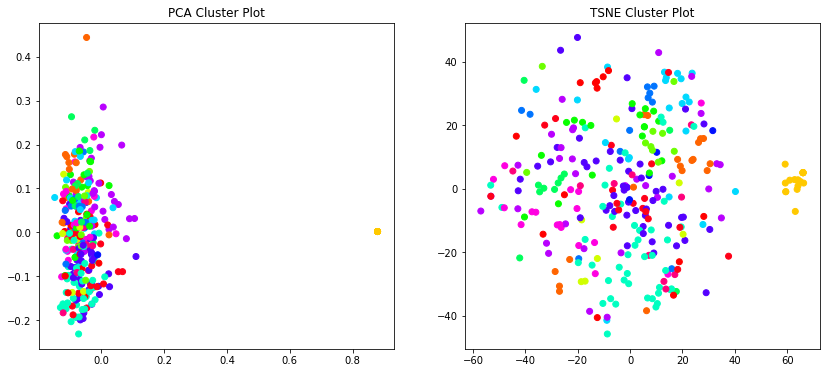

In [131]:
#Plotting the PCA CLuster and TSNE Cluster
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

In [88]:
# Top keywords in each cluster
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
shift,realli,staff,good,friend,manag,great,work,job,easi

Cluster 1
mcdonald,team,stress,time,good,job,environ,work,pace,fast

Cluster 2
ounc,staff,custom,work,pay,howev,good,treat,experi,year

Cluster 3
franchis,shift,staff,good,job,peopl,mcdonald,manag,work,store

Cluster 4
learn,serv,job,till,servic,day,order,clean,food,custom

Cluster 5
team,job,day,fun,mcdonald,peopl,custom,great,lot,work

Cluster 6
custom,new,mcdonald,communic,confid,help,team,learn,work,skill

Cluster 7
pay,long,week,job,break,manag,time,work,shift,hour

Cluster 8
staff,everyon,someth,busi,manag,love,friend,work,help,alway

Cluster 9
fun,stress,enjoy,peopl,job,day,mcdonald,work,time,busi

Cluster 10
employe,work,train,rule,manag,staff,health,safeti,procedur,follow

Cluster 11
crew,member,make,treat,job,peopl,staff,like,work,manag

Cluster 12
time,staff,manag,hour,friend,pay,job,place,work,good

Cluster 13
place,good,peopl,mcdonald,time,balanc,job,work,life,great

Cluster 14
time,experi,manag,given,com